<a href="https://colab.research.google.com/github/MargaretMugo/Attention-U-net-for-fetal-head-circumference-measurement/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install click==8.0.3

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
from scipy.ndimage import rotate
import albumentations as A
from tensorflow import keras
import tensorflow as tf

In [ ]:
img_directory="/content/drive/MyDrive/project_images/training_set/Augmented/images/"
mask_directory="/content/drive/MyDrive/project_images/training_set/Augmented/annotation/"
test_directory="/content/drive/MyDrive/project_images/test_set/"
num_img = 8000
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL =3

Data preprocessing

In [ ]:
image_names = glob.glob(img_directory + '*.png')

image_names.sort()

print(len(image_names))

image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(128,128)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

#expand_dims adds another dimension to add an extra dimension
image_dataset=np.expand_dims(image_dataset, axis=3)


8000
(8000, 128, 128)


In [ ]:
mask_names = glob.glob(mask_directory + '*.png')

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(128,128)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)


In [ ]:
mask_dataset.shape

(8000, 128, 128, 1)

In [ ]:
print(len(image_dataset))

8000


In [ ]:
#initializes 3 NumPy arrays X_Train_seg, Y_Train_seg, Label_seg
#X_train_seg depends on IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL
X_train_seg = np.zeros((len(image_dataset), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
Y_train_seg = np.zeros((len(mask_dataset), IMG_HEIGHT, IMG_WIDTH, 1))
#Initialized at zero will be filled later on.
Label_seg = np.zeros(len(mask_dataset), dtype=np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split
def load_data(path, split=0.2):
    train_images = sorted(glob(os.path.join(path, "/content/drive/MyDrive/project_images/training_set/Augmented/images/", "*HC.png")))
    train_masks = sorted(glob(os.path.join(path, "/content/drive/MyDrive/project_images/training_set/Augmented/annotation/", "*HC.png")))
    X_test= sorted(glob(os.path.join(path, "test_images", "*HC.png")))
    y_test= sorted(glob(os.path.join(path, "test_masks", "*HC.png")))
X_train,X_test,y_train,y_test=train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

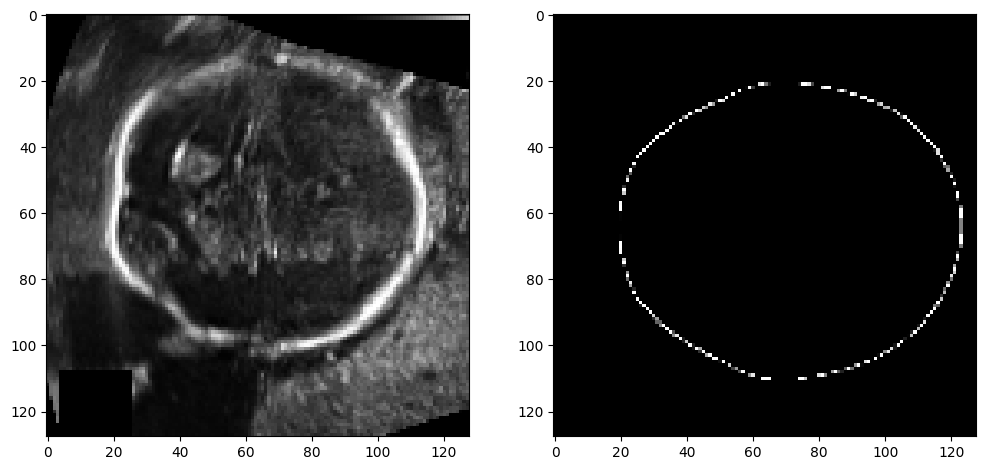

In [ ]:
import random
image_number=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show()

X_train[image_number,:,:,0].shape

**Augmentation**

In [ ]:
images_to_generate=8000

images_path="/content/drive/MyDrive/project_images/training_set/images/" #path to original images
masks_path = "/content/drive/MyDrive/project_images/training_set/annotations/"
img_augmented_path="/content/drive/MyDrive/project_images/training_set/Augmented/images/" # path to store augmented images
msk_augmented_path="/content/drive/MyDrive/project_images/training_set/Augmented/annotation" # path to store augmented images
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array
    masks.append(os.path.join(masks_path,msk))


aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    #A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=1)
    ]
)

#random.seed(42)

i=1   # variable to iterate till images_to_generate


while i<=images_to_generate:
    number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
    image = images[number]
    mask = masks[number]
    print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)

    augmented = aug(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']


    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_9.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_10.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_11.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_12.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_13.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_14.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_15.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_16.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_17.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_18.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_19.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_21.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_22.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_23.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_24.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_25.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_26.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_27.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_29.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/775_HC.png /content/drive/MyDrive/project_images/training_set/annotations/774_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_30.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_31.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_32.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_33.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_34.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/766_HC.png /content/drive/MyDrive/project_images/training_set/annotations/766_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_35.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_36.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_37.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_38.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_39.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_40.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_41.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_42.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_43.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_44.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_45.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_46.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_47.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_48.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_49.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_50.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_51.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_52.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_53.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_54.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_55.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_56.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_57.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_58.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_59.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_60.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_61.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_62.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/641_HC.png /content/drive/MyDrive/project_images/training_set/annotations/641_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_63.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_64.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_65.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_66.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_67.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_68.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_69.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_70.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_71.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_72.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_73.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_74.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_75.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_76.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_77.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/791_HC.png /content/drive/MyDrive/project_images/training_set/annotations/794_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_80.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_81.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_82.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_83.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_84.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_85.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/641_HC.png /content/drive/MyDrive/project_images/training_set/annotations/641_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_86.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_87.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_89.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_90.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_91.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_93.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/087_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_94.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_95.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/257_HC.png /content/drive/MyDrive/project_images/training_set/annotations/258_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_96.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_97.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_98.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_99.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_HC.png /content/drive/MyDrive/project_images/training_set/annotations/051_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/634_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/791_HC.png /content/drive/MyDrive/project_images/training_set/annotations/794_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/766_HC.png /content/drive/MyDrive/project_images/training_set/annotations/766_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/539_HC.png /content/drive/MyDrive/project_images/training_set/annotations/538_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_191.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/129_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/447_HC.png /content/drive/MyDrive/project_images/training_set/annotations/446_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/641_HC.png /content/drive/MyDrive/project_images/training_set/annotations/641_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/688_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/058_HC.png /content/drive/MyDrive/project_images/training_set/annotations/057_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/569_HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/498_HC.png /content/drive/MyDrive/project_images/training_set/annotations/496_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_308.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/735_HC.png /content/drive/MyDrive/project_images/training_set/annotations/737_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/202_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/754_HC.png /content/drive/MyDrive/project_images/training_set/annotations/753_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/565_HC.png /content/drive/MyDrive/project_images/training_set/annotations/562_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/087_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/215_HC.png /content/drive/MyDrive/project_images/training_set/annotations/219_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/510_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/615_HC.png /content/drive/MyDrive/project_images/training_set/annotations/616_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/110_HC.png /content/drive/MyDrive/project_images/training_set/annotations/110_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/267_HC.png /content/drive/MyDrive/project_images/training_set/annotations/263_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_HC.png /content/drive/MyDrive/project_images/training_set/annotations/337_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/260_HC.png /content/drive/MyDrive/project_images/training_set/annotations/266_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/228_HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/251_HC.png /content/drive/MyDrive/project_images/training_set/annotations/251_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/488_HC.png /content/drive/MyDrive/project_images/training_set/annotations/489_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/305_HC.png /content/drive/MyDrive/project_images/training_set/annotations/307_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/539_HC.png /content/drive/MyDrive/project_images/training_set/annotations/538_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/042_HC.png /content/drive/MyDrive/project_images/training_set/annotations/045_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/593_HC.png /content/drive/MyDrive/project_images/training_set/annotations/595_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/101_HC.png /content/drive/MyDrive/project_images/training_set/annotations/098_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/296_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/678_HC.png /content/drive/MyDrive/project_images/training_set/annotations/684_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/555_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/101_HC.png /content/drive/MyDrive/project_images/training_set/annotations/098_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_513.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/204_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/797_HC.png /content/drive/MyDrive/project_images/training_set/annotations/797_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/510_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/363_HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/498_HC.png /content/drive/MyDrive/project_images/training_set/annotations/496_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/259_HC.png /content/drive/MyDrive/project_images/training_set/annotations/262_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/362_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_601.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/589_HC.png /content/drive/MyDrive/project_images/training_set/annotations/589_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_624.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/594_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_671.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/201_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/519_HC.png /content/drive/MyDrive/project_images/training_set/annotations/517_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/700_HC.png /content/drive/MyDrive/project_images/training_set/annotations/701_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/458_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/688_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/355_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_749.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/190_HC.png /content/drive/MyDrive/project_images/training_set/annotations/189_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/239_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/042_HC.png /content/drive/MyDrive/project_images/training_set/annotations/045_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/096_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/473_HC.png /content/drive/MyDrive/project_images/training_set/annotations/472_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/798_HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/803_HC.png /content/drive/MyDrive/project_images/training_set/annotations/802_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/699_HC.png /content/drive/MyDrive/project_images/training_set/annotations/697_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/724_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/239_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/305_HC.png /content/drive/MyDrive/project_images/training_set/annotations/307_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/067_HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/641_HC.png /content/drive/MyDrive/project_images/training_set/annotations/641_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/251_HC.png /content/drive/MyDrive/project_images/training_set/annotations/251_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_HC.png /content/drive/MyDrive/project_images/training_set/annotations/280_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/569_HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/116_HC.png /content/drive/MyDrive/project_images/training_set/annotations/111_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/134_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/722_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/096_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/417_HC.png /content/drive/MyDrive/project_images/training_set/annotations/416_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/687_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/355_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1004.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/257_HC.png /content/drive/MyDrive/project_images/training_set/annotations/258_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1023.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/191_HC.png /content/drive/MyDrive/project_images/training_set/annotations/186_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1050.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1060.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1073.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1074.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/654_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/215_HC.png /content/drive/MyDrive/project_images/training_set/annotations/219_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/488_HC.png /content/drive/MyDrive/project_images/training_set/annotations/489_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/791_HC.png /content/drive/MyDrive/project_images/training_set/annotations/794_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/751_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_HC.png /content/drive/MyDrive/project_images/training_set/annotations/330_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/384_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/232_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/737_HC.png /content/drive/MyDrive/project_images/training_set/annotations/735_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/202_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/552_HC.png /content/drive/MyDrive/project_images/training_set/annotations/551_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/687_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/787_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_HC.png /content/drive/MyDrive/project_images/training_set/annotations/396_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_HC.png /content/drive/MyDrive/project_images/training_set/annotations/555_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1308.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/793_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/168_HC.png /content/drive/MyDrive/project_images/training_set/annotations/170_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/184_HC.png /content/drive/MyDrive/project_images/training_set/annotations/180_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/239_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/740_HC.png /content/drive/MyDrive/project_images/training_set/annotations/739_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/576_HC.png /content/drive/MyDrive/project_images/training_set/annotations/577_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/278_HC.png /content/drive/MyDrive/project_images/training_set/annotations/280_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/714_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/632_HC.png /content/drive/MyDrive/project_images/training_set/annotations/632_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_HC.png /content/drive/MyDrive/project_images/training_set/annotations/738_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/171_HC.png /content/drive/MyDrive/project_images/training_set/annotations/168_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/535_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/261_HC.png /content/drive/MyDrive/project_images/training_set/annotations/261_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/232_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/573_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/418_HC.png /content/drive/MyDrive/project_images/training_set/annotations/422_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/803_HC.png /content/drive/MyDrive/project_images/training_set/annotations/802_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/797_HC.png /content/drive/MyDrive/project_images/training_set/annotations/797_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/491_HC.png /content/drive/MyDrive/project_images/training_set/annotations/488_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/702_HC.png /content/drive/MyDrive/project_images/training_set/annotations/696_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/235_HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/058_HC.png /content/drive/MyDrive/project_images/training_set/annotations/057_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/065_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1513.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/766_HC.png /content/drive/MyDrive/project_images/training_set/annotations/766_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/667_HC.png /content/drive/MyDrive/project_images/training_set/annotations/667_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/320_HC.png /content/drive/MyDrive/project_images/training_set/annotations/316_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/202_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/362_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/101_HC.png /content/drive/MyDrive/project_images/training_set/annotations/098_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/586_HC.png /content/drive/MyDrive/project_images/training_set/annotations/585_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/610_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/569_HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1601.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_HC.png /content/drive/MyDrive/project_images/training_set/annotations/330_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_HC.png /content/drive/MyDrive/project_images/training_set/annotations/311_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1624.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1651.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/754_HC.png /content/drive/MyDrive/project_images/training_set/annotations/753_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/114_HC.png /content/drive/MyDrive/project_images/training_set/annotations/113_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/526_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/524_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/802_HC.png /content/drive/MyDrive/project_images/training_set/annotations/805_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/116_HC.png /content/drive/MyDrive/project_images/training_set/annotations/111_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/267_HC.png /content/drive/MyDrive/project_images/training_set/annotations/263_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/540_HC.png /content/drive/MyDrive/project_images/training_set/annotations/542_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/634_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/071_HC.png /content/drive/MyDrive/project_images/training_set/annotations/070_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/320_HC.png /content/drive/MyDrive/project_images/training_set/annotations/316_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/154_HC.png /content/drive/MyDrive/project_images/training_set/annotations/149_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/192_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/101_HC.png /content/drive/MyDrive/project_images/training_set/annotations/098_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/798_HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/632_HC.png /content/drive/MyDrive/project_images/training_set/annotations/632_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/355_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/236_HC.png /content/drive/MyDrive/project_images/training_set/annotations/238_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_HC.png /content/drive/MyDrive/project_images/training_set/annotations/555_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/775_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/539_HC.png /content/drive/MyDrive/project_images/training_set/annotations/538_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/691_HC.png /content/drive/MyDrive/project_images/training_set/annotations/693_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_HC.png /content/drive/MyDrive/project_images/training_set/annotations/065_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_HC.png /content/drive/MyDrive/project_images/training_set/annotations/266_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/720_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/722_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/305_HC.png /content/drive/MyDrive/project_images/training_set/annotations/307_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/593_HC.png /content/drive/MyDrive/project_images/training_set/annotations/595_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/289_HC.png /content/drive/MyDrive/project_images/training_set/annotations/287_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/114_HC.png /content/drive/MyDrive/project_images/training_set/annotations/113_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_HC.png /content/drive/MyDrive/project_images/training_set/annotations/555_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/150_HC.png /content/drive/MyDrive/project_images/training_set/annotations/151_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/510_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/331_HC.png /content/drive/MyDrive/project_images/training_set/annotations/328_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/154_HC.png /content/drive/MyDrive/project_images/training_set/annotations/149_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/096_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_1999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2001.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2004.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/310_HC.png /content/drive/MyDrive/project_images/training_set/annotations/308_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/256_HC.png /content/drive/MyDrive/project_images/training_set/annotations/257_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/552_HC.png /content/drive/MyDrive/project_images/training_set/annotations/551_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/533_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2050.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2060.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/304_HC.png /content/drive/MyDrive/project_images/training_set/annotations/301_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/225_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2073.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2074.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/528_HC.png /content/drive/MyDrive/project_images/training_set/annotations/528_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/228_HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/087_HC.png

<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


 /content/drive/MyDrive/project_images/training_set/annotations/088_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/135_HC.png /content/drive/MyDrive/project_images/training_set/annotations/134_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/491_HC.png /content/drive/MyDrive/project_images/training_set/annotations/488_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/310_HC.png /content/drive/MyDrive/project_images/training_set/annotations/308_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/320_HC.png /content/drive/MyDrive/project_images/training_set/annotations/316_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/281_HC.png /content/drive/MyDrive/project_images/training_set/annotations/283_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/154_HC.png /content/drive/MyDrive/project_images/training_set/annotations/149_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/331_HC.png /content/drive/MyDrive/project_images/training_set/annotations/328_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/096_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/477_HC.png /content/drive/MyDrive/project_images/training_set/annotations/474_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/702_HC.png /content/drive/MyDrive/project_images/training_set/annotations/696_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/569_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/191_HC.png /content/drive/MyDrive/project_images/training_set/annotations/186_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/522_HC.png /content/drive/MyDrive/project_images/training_set/annotations/522_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/552_HC.png /content/drive/MyDrive/project_images/training_set/annotations/551_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_HC.png /content/drive/MyDrive/project_images/training_set/annotations/065_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/256_HC.png /content/drive/MyDrive/project_images/training_set/annotations/257_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/285_HC.png /content/drive/MyDrive/project_images/training_set/annotations/288_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/134_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/363_HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/565_HC.png /content/drive/MyDrive/project_images/training_set/annotations/562_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/775_HC.png /content/drive/MyDrive/project_images/training_set/annotations/774_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_HC.png /content/drive/MyDrive/project_images/training_set/annotations/776_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/114_HC.png /content/drive/MyDrive/project_images/training_set/annotations/113_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/256_HC.png /content/drive/MyDrive/project_images/training_set/annotations/257_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/555_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_HC.png /content/drive/MyDrive/project_images/training_set/annotations/400_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/524_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/654_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2601.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/735_HC.png /content/drive/MyDrive/project_images/training_set/annotations/737_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/374_HC.png /content/drive/MyDrive/project_images/training_set/annotations/375_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/477_HC.png /content/drive/MyDrive/project_images/training_set/annotations/474_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/310_HC.png /content/drive/MyDrive/project_images/training_set/annotations/308_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/320_HC.png /content/drive/MyDrive/project_images/training_set/annotations/316_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2624.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/256_HC.png /content/drive/MyDrive/project_images/training_set/annotations/257_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/287_HC.png /content/drive/MyDrive/project_images/training_set/annotations/286_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/688_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/296_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2671.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/478_HC.png /content/drive/MyDrive/project_images/training_set/annotations/478_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/358_HC.png /content/drive/MyDrive/project_images/training_set/annotations/358_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2749.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/309_HC.png /content/drive/MyDrive/project_images/training_set/annotations/309_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/498_HC.png /content/drive/MyDrive/project_images/training_set/annotations/496_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/217_HC.png /content/drive/MyDrive/project_images/training_set/annotations/216_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/196_HC.png /content/drive/MyDrive/project_images/training_set/annotations/199_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/247_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/048_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/247_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/798_HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/478_HC.png /content/drive/MyDrive/project_images/training_set/annotations/478_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/540_HC.png /content/drive/MyDrive/project_images/training_set/annotations/542_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/757_HC.png /content/drive/MyDrive/project_images/training_set/annotations/757_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/699_HC.png /content/drive/MyDrive/project_images/training_set/annotations/697_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/522_HC.png /content/drive/MyDrive/project_images/training_set/annotations/522_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/724_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/722_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/251_HC.png /content/drive/MyDrive/project_images/training_set/annotations/251_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/287_HC.png /content/drive/MyDrive/project_images/training_set/annotations/286_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/280_HC.png /content/drive/MyDrive/project_images/training_set/annotations/282_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_HC.png /content/drive/MyDrive/project_images/training_set/annotations/266_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/135_HC.png /content/drive/MyDrive/project_images/training_set/annotations/134_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/754_HC.png /content/drive/MyDrive/project_images/training_set/annotations/753_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/380_HC.png /content/drive/MyDrive/project_images/training_set/annotations/379_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/380_HC.png /content/drive/MyDrive/project_images/training_set/annotations/379_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_HC.png /content/drive/MyDrive/project_images/training_set/annotations/266_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/396_HC.png /content/drive/MyDrive/project_images/training_set/annotations/398_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/418_HC.png /content/drive/MyDrive/project_images/training_set/annotations/422_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/120_HC.png /content/drive/MyDrive/project_images/training_set/annotations/120_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_2999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3004.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/304_HC.png /content/drive/MyDrive/project_images/training_set/annotations/301_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/380_HC.png /content/drive/MyDrive/project_images/training_set/annotations/379_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3023.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/331_HC.png /content/drive/MyDrive/project_images/training_set/annotations/328_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3036.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3050.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/594_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/114_HC.png /content/drive/MyDrive/project_images/training_set/annotations/113_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3073.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/413_HC.png /content/drive/MyDrive/project_images/training_set/annotations/415_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/067_HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3097.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/642_HC.png /content/drive/MyDrive/project_images/training_set/annotations/646_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/654_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_HC.png /content/drive/MyDrive/project_images/training_set/annotations/311_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/150_HC.png /content/drive/MyDrive/project_images/training_set/annotations/151_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/642_HC.png /content/drive/MyDrive/project_images/training_set/annotations/646_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/477_HC.png /content/drive/MyDrive/project_images/training_set/annotations/474_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/760_HC.png /content/drive/MyDrive/project_images/training_set/annotations/762_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/304_HC.png /content/drive/MyDrive/project_images/training_set/annotations/301_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/413_HC.png /content/drive/MyDrive/project_images/training_set/annotations/415_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/304_HC.png /content/drive/MyDrive/project_images/training_set/annotations/301_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_HC.png /content/drive/MyDrive/project_images/training_set/annotations/280_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/281_HC.png /content/drive/MyDrive/project_images/training_set/annotations/283_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/569_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/184_HC.png /content/drive/MyDrive/project_images/training_set/annotations/180_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3308.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/655_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/183_HC.png /content/drive/MyDrive/project_images/training_set/annotations/183_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/355_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/714_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/071_HC.png /content/drive/MyDrive/project_images/training_set/annotations/070_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/071_HC.png /content/drive/MyDrive/project_images/training_set/annotations/070_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/702_HC.png /content/drive/MyDrive/project_images/training_set/annotations/696_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/790_HC.png /content/drive/MyDrive/project_images/training_set/annotations/791_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/655_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/655_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_HC.png /content/drive/MyDrive/project_images/training_set/annotations/776_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/720_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/722_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/101_HC.png /content/drive/MyDrive/project_images/training_set/annotations/098_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/015_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/301_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/447_HC.png /content/drive/MyDrive/project_images/training_set/annotations/446_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/576_HC.png /content/drive/MyDrive/project_images/training_set/annotations/577_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/374_HC.png /content/drive/MyDrive/project_images/training_set/annotations/375_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/194_HC.png /content/drive/MyDrive/project_images/training_set/annotations/194_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_HC.png /content/drive/MyDrive/project_images/training_set/annotations/591_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/615_HC.png /content/drive/MyDrive/project_images/training_set/annotations/616_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/470_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/700_HC.png /content/drive/MyDrive/project_images/training_set/annotations/701_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/632_HC.png /content/drive/MyDrive/project_images/training_set/annotations/632_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_HC.png /content/drive/MyDrive/project_images/training_set/annotations/065_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/116_HC.png /content/drive/MyDrive/project_images/training_set/annotations/111_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/340_HC.png /content/drive/MyDrive/project_images/training_set/annotations/337_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/470_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/691_HC.png /content/drive/MyDrive/project_images/training_set/annotations/693_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/530_HC.png /content/drive/MyDrive/project_images/training_set/annotations/529_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/447_HC.png /content/drive/MyDrive/project_images/training_set/annotations/446_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3624.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/700_HC.png /content/drive/MyDrive/project_images/training_set/annotations/701_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3651.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/722_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/797_HC.png /content/drive/MyDrive/project_images/training_set/annotations/797_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/192_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/135_HC.png /content/drive/MyDrive/project_images/training_set/annotations/134_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3671.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/717_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/714_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/766_HC.png /content/drive/MyDrive/project_images/training_set/annotations/766_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3749.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/775_HC.png /content/drive/MyDrive/project_images/training_set/annotations/774_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/150_HC.png /content/drive/MyDrive/project_images/training_set/annotations/151_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/253_HC.png /content/drive/MyDrive/project_images/training_set/annotations/253_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/236_HC.png /content/drive/MyDrive/project_images/training_set/annotations/238_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/289_HC.png /content/drive/MyDrive/project_images/training_set/annotations/287_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/257_HC.png /content/drive/MyDrive/project_images/training_set/annotations/258_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/196_HC.png /content/drive/MyDrive/project_images/training_set/annotations/199_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/540_HC.png /content/drive/MyDrive/project_images/training_set/annotations/542_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/129_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/700_HC.png /content/drive/MyDrive/project_images/training_set/annotations/701_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/309_HC.png /content/drive/MyDrive/project_images/training_set/annotations/309_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/714_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/803_HC.png /content/drive/MyDrive/project_images/training_set/annotations/802_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/281_HC.png /content/drive/MyDrive/project_images/training_set/annotations/283_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/491_HC.png /content/drive/MyDrive/project_images/training_set/annotations/488_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/015_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_HC.png /content/drive/MyDrive/project_images/training_set/annotations/396_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/610_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/535_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/573_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/374_HC.png /content/drive/MyDrive/project_images/training_set/annotations/375_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/491_HC.png /content/drive/MyDrive/project_images/training_set/annotations/488_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/552_HC.png /content/drive/MyDrive/project_images/training_set/annotations/551_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/775_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/687_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/120_HC.png /content/drive/MyDrive/project_images/training_set/annotations/120_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/171_HC.png /content/drive/MyDrive/project_images/training_set/annotations/168_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/790_HC.png /content/drive/MyDrive/project_images/training_set/annotations/791_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_3999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4001.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4004.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/471_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/470_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4023.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_HC.png /content/drive/MyDrive/project_images/training_set/annotations/582_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4036.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4050.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/171_HC.png /content/drive/MyDrive/project_images/training_set/annotations/168_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4060.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/530_HC.png /content/drive/MyDrive/project_images/training_set/annotations/529_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4073.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4074.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/499_HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/632_HC.png /content/drive/MyDrive/project_images/training_set/annotations/632_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4097.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/071_HC.png /content/drive/MyDrive/project_images/training_set/annotations/070_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_HC.png /content/drive/MyDrive/project_images/training_set/annotations/591_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/802_HC.png /content/drive/MyDrive/project_images/training_set/annotations/805_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/417_HC.png /content/drive/MyDrive/project_images/training_set/annotations/416_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/247_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/237_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/331_HC.png /content/drive/MyDrive/project_images/training_set/annotations/328_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/473_HC.png /content/drive/MyDrive/project_images/training_set/annotations/472_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/529_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/714_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4191.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/203_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/202_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/150_HC.png /content/drive/MyDrive/project_images/training_set/annotations/151_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/583_HC.png /content/drive/MyDrive/project_images/training_set/annotations/582_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/087_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/678_HC.png /content/drive/MyDrive/project_images/training_set/annotations/684_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/528_HC.png /content/drive/MyDrive/project_images/training_set/annotations/528_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/168_HC.png /content/drive/MyDrive/project_images/training_set/annotations/170_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/203_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/202_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/358_HC.png /content/drive/MyDrive/project_images/training_set/annotations/358_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/358_HC.png /content/drive/MyDrive/project_images/training_set/annotations/358_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/184_HC.png /content/drive/MyDrive/project_images/training_set/annotations/180_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_HC.png /content/drive/MyDrive/project_images/training_set/annotations/738_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/760_HC.png /content/drive/MyDrive/project_images/training_set/annotations/762_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4308.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/525_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/236_HC.png /content/drive/MyDrive/project_images/training_set/annotations/238_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_HC.png /content/drive/MyDrive/project_images/training_set/annotations/311_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/458_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/498_HC.png /content/drive/MyDrive/project_images/training_set/annotations/496_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/716_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/196_HC.png /content/drive/MyDrive/project_images/training_set/annotations/199_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/042_HC.png /content/drive/MyDrive/project_images/training_set/annotations/045_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/418_HC.png /content/drive/MyDrive/project_images/training_set/annotations/422_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/769_HC.png /content/drive/MyDrive/project_images/training_set/annotations/769_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/251_HC.png /content/drive/MyDrive/project_images/training_set/annotations/251_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/232_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/773_HC.png /content/drive/MyDrive/project_images/training_set/annotations/776_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/740_HC.png /content/drive/MyDrive/project_images/training_set/annotations/739_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/797_HC.png /content/drive/MyDrive/project_images/training_set/annotations/797_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/285_HC.png /content/drive/MyDrive/project_images/training_set/annotations/288_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/539_HC.png /content/drive/MyDrive/project_images/training_set/annotations/538_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/018_HC.png /content/drive/MyDrive/project_images/training_set/annotations/018_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/201_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/586_HC.png /content/drive/MyDrive/project_images/training_set/annotations/585_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4601.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/716_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/539_HC.png /content/drive/MyDrive/project_images/training_set/annotations/538_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/362_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/301_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/634_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4651.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/533_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_HC.png /content/drive/MyDrive/project_images/training_set/annotations/396_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4671.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/678_HC.png /content/drive/MyDrive/project_images/training_set/annotations/684_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/791_HC.png /content/drive/MyDrive/project_images/training_set/annotations/794_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/655_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/065_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/195_HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/757_HC.png /content/drive/MyDrive/project_images/training_set/annotations/757_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/362_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/247_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4749.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/194_HC.png /content/drive/MyDrive/project_images/training_set/annotations/194_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/129_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/120_HC.png /content/drive/MyDrive/project_images/training_set/annotations/120_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/740_HC.png /content/drive/MyDrive/project_images/training_set/annotations/739_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/615_HC.png /content/drive/MyDrive/project_images/training_set/annotations/616_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/301_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/573_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/642_HC.png /content/drive/MyDrive/project_images/training_set/annotations/646_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/196_HC.png /content/drive/MyDrive/project_images/training_set/annotations/199_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/285_HC.png /content/drive/MyDrive/project_images/training_set/annotations/288_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/113_HC.png /content/drive/MyDrive/project_images/training_set/annotations/116_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_HC.png /content/drive/MyDrive/project_images/training_set/annotations/280_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/576_HC.png /content/drive/MyDrive/project_images/training_set/annotations/577_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_HC.png /content/drive/MyDrive/project_images/training_set/annotations/330_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_HC.png /content/drive/MyDrive/project_images/training_set/annotations/337_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/203_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/202_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/210_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/204_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/798_HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/706_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/533_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_4999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5004.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/530_HC.png /content/drive/MyDrive/project_images/training_set/annotations/529_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/042_HC.png /content/drive/MyDrive/project_images/training_set/annotations/045_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/309_HC.png /content/drive/MyDrive/project_images/training_set/annotations/309_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5036.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/586_HC.png /content/drive/MyDrive/project_images/training_set/annotations/585_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/565_HC.png /content/drive/MyDrive/project_images/training_set/annotations/562_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5050.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/171_HC.png /content/drive/MyDrive/project_images/training_set/annotations/168_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5060.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/655_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5073.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/790_HC.png /content/drive/MyDrive/project_images/training_set/annotations/791_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/740_HC.png /content/drive/MyDrive/project_images/training_set/annotations/739_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5097.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/191_HC.png /content/drive/MyDrive/project_images/training_set/annotations/186_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/287_HC.png /content/drive/MyDrive/project_images/training_set/annotations/286_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/586_HC.png /content/drive/MyDrive/project_images/training_set/annotations/585_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/754_HC.png /content/drive/MyDrive/project_images/training_set/annotations/753_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/071_HC.png /content/drive/MyDrive/project_images/training_set/annotations/070_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/110_HC.png /content/drive/MyDrive/project_images/training_set/annotations/110_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/058_HC.png /content/drive/MyDrive/project_images/training_set/annotations/057_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/601_HC.png /content/drive/MyDrive/project_images/training_set/annotations/602_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/615_HC.png /content/drive/MyDrive/project_images/training_set/annotations/616_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/485_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/530_HC.png /content/drive/MyDrive/project_images/training_set/annotations/529_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/363_HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5191.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_HC.png /content/drive/MyDrive/project_images/training_set/annotations/400_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/129_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/787_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/477_HC.png /content/drive/MyDrive/project_images/training_set/annotations/474_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/691_HC.png /content/drive/MyDrive/project_images/training_set/annotations/693_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/667_HC.png /content/drive/MyDrive/project_images/training_set/annotations/667_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/781_HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/797_HC.png /content/drive/MyDrive/project_images/training_set/annotations/797_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_HC.png /content/drive/MyDrive/project_images/training_set/annotations/065_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/285_HC.png /content/drive/MyDrive/project_images/training_set/annotations/288_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/348_HC.png /content/drive/MyDrive/project_images/training_set/annotations/346_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/576_HC.png /content/drive/MyDrive/project_images/training_set/annotations/577_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/296_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/645_HC.png /content/drive/MyDrive/project_images/training_set/annotations/645_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_HC.png /content/drive/MyDrive/project_images/training_set/annotations/330_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5308.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/155_HC.png /content/drive/MyDrive/project_images/training_set/annotations/159_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/217_HC.png /content/drive/MyDrive/project_images/training_set/annotations/216_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/624_HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/655_HC.png /content/drive/MyDrive/project_images/training_set/annotations/656_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/312_HC.png /content/drive/MyDrive/project_images/training_set/annotations/311_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/000_HC.png /content/drive/MyDrive/project_images/training_set/annotations/003_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/158_HC.png /content/drive/MyDrive/project_images/training_set/annotations/154_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/042_HC.png /content/drive/MyDrive/project_images/training_set/annotations/045_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/668_HC.png /content/drive/MyDrive/project_images/training_set/annotations/664_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/048_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/741_HC.png

<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


 /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/117_HC.png /content/drive/MyDrive/project_images/training_set/annotations/118_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/267_HC.png /content/drive/MyDrive/project_images/training_set/annotations/263_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/135_HC.png /content/drive/MyDrive/project_images/training_set/annotations/134_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/528_HC.png /content/drive/MyDrive/project_images/training_set/annotations/528_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5479.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5483.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/408_HC.png /content/drive/MyDrive/project_images/training_set/annotations/407_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_HC.png /content/drive/MyDrive/project_images/training_set/annotations/201_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/116_HC.png /content/drive/MyDrive/project_images/training_set/annotations/111_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_HC.png /content/drive/MyDrive/project_images/training_set/annotations/615_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5513.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/775_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/067_HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/306_HC.png /content/drive/MyDrive/project_images/training_set/annotations/310_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_HC.png /content/drive/MyDrive/project_images/training_set/annotations/051_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/185_HC.png /content/drive/MyDrive/project_images/training_set/annotations/190_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/524_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/116_HC.png /content/drive/MyDrive/project_images/training_set/annotations/111_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/211_HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/569_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/802_HC.png /content/drive/MyDrive/project_images/training_set/annotations/805_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/775_HC.png /content/drive/MyDrive/project_images/training_set/annotations/774_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5601.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/798_HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/048_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/320_HC.png /content/drive/MyDrive/project_images/training_set/annotations/316_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/569_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/065_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/267_HC.png /content/drive/MyDrive/project_images/training_set/annotations/263_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/098_HC.png /content/drive/MyDrive/project_images/training_set/annotations/097_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/657_HC.png /content/drive/MyDrive/project_images/training_set/annotations/660_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/310_HC.png /content/drive/MyDrive/project_images/training_set/annotations/308_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/535_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/593_HC.png /content/drive/MyDrive/project_images/training_set/annotations/595_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5651.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/478_HC.png /content/drive/MyDrive/project_images/training_set/annotations/478_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/058_HC.png /content/drive/MyDrive/project_images/training_set/annotations/057_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/135_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_HC.png /content/drive/MyDrive/project_images/training_set/annotations/539_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/163_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_HC.png /content/drive/MyDrive/project_images/training_set/annotations/729_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/281_HC.png /content/drive/MyDrive/project_images/training_set/annotations/283_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/012_HC.png /content/drive/MyDrive/project_images/training_set/annotations/012_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/046_HC.png /content/drive/MyDrive/project_images/training_set/annotations/046_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/105_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/055_HC.png /content/drive/MyDrive/project_images/training_set/annotations/054_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/589_HC.png /content/drive/MyDrive/project_images/training_set/annotations/589_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/161_HC.png /content/drive/MyDrive/project_images/training_set/annotations/163_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/002_HC.png /content/drive/MyDrive/project_images/training_set/annotations/001_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/573_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/268_HC.png /content/drive/MyDrive/project_images/training_set/annotations/268_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5749.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/218_HC.png /content/drive/MyDrive/project_images/training_set/annotations/220_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/399_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/760_HC.png /content/drive/MyDrive/project_images/training_set/annotations/762_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/238_HC.png /content/drive/MyDrive/project_images/training_set/annotations/235_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/282_HC.png /content/drive/MyDrive/project_images/training_set/annotations/281_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/740_HC.png /content/drive/MyDrive/project_images/training_set/annotations/739_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/461_HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/309_HC.png /content/drive/MyDrive/project_images/training_set/annotations/309_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_HC.png /content/drive/MyDrive/project_images/training_set/annotations/400_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/289_HC.png /content/drive/MyDrive/project_images/training_set/annotations/287_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/649_HC.png /content/drive/MyDrive/project_images/training_set/annotations/650_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/757_HC.png /content/drive/MyDrive/project_images/training_set/annotations/757_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/512_HC.png 

<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/074_HC.png /content/drive/MyDrive/project_images/training_set/annotations/073_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/202_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/365_HC.png /content/drive/MyDrive/project_images/training_set/annotations/370_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_HC.png /content/drive/MyDrive/project_images/training_set/annotations/221_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/552_HC.png /content/drive/MyDrive/project_images/training_set/annotations/551_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/684_HC.png /content/drive/MyDrive/project_images/training_set/annotations/683_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/770_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/456_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/478_HC.png /content/drive/MyDrive/project_images/training_set/annotations/478_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/443_HC.png /content/drive/MyDrive/project_images/training_set/annotations/443_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/691_HC.png /content/drive/MyDrive/project_images/training_set/annotations/693_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/327_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/331_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/699_HC.png /content/drive/MyDrive/project_images/training_set/annotations/697_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/470_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/232_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/696_HC.png /content/drive/MyDrive/project_images/training_set/annotations/698_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/525_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/735_HC.png /content/drive/MyDrive/project_images/training_set/annotations/737_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/463_HC.png /content/drive/MyDrive/project_images/training_set/annotations/467_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/521_HC.png /content/drive/MyDrive/project_images/training_set/annotations/519_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/052_HC.png /content/drive/MyDrive/project_images/training_set/annotations/058_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/636_HC.png /content/drive/MyDrive/project_images/training_set/annotations/637_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/202_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/240_HC.png /content/drive/MyDrive/project_images/training_set/annotations/242_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/738_HC.png /content/drive/MyDrive/project_images/training_set/annotations/734_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/109_HC.png /content/drive/MyDrive/project_images/training_set/annotations/109_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_HC.png /content/drive/MyDrive/project_images/training_set/annotations/591_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_5999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6001.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/247_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/222_HC.png /content/drive/MyDrive/project_images/training_set/annotations/224_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6013.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/749_HC.png /content/drive/MyDrive/project_images/training_set/annotations/747_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6023.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/526_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/524_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6025.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/120_HC.png /content/drive/MyDrive/project_images/training_set/annotations/120_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/460_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/134_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6036.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/368_HC.png /content/drive/MyDrive/project_images/training_set/annotations/367_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/267_HC.png /content/drive/MyDrive/project_images/training_set/annotations/263_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6047.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/171_HC.png /content/drive/MyDrive/project_images/training_set/annotations/168_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_HC.png /content/drive/MyDrive/project_images/training_set/annotations/197_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/239_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/786_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/205_HC.png /content/drive/MyDrive/project_images/training_set/annotations/209_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6060.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/202_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/194_HC.png /content/drive/MyDrive/project_images/training_set/annotations/194_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/029_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6074.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/430_HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_HC.png /content/drive/MyDrive/project_images/training_set/annotations/233_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/367_HC.png /content/drive/MyDrive/project_images/training_set/annotations/369_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/283_HC.png /content/drive/MyDrive/project_images/training_set/annotations/279_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6095.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6097.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/236_HC.png /content/drive/MyDrive/project_images/training_set/annotations/238_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/196_HC.png /content/drive/MyDrive/project_images/training_set/annotations/199_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/331_HC.png /content/drive/MyDrive/project_images/training_set/annotations/328_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/114_HC.png /content/drive/MyDrive/project_images/training_set/annotations/113_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/048_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_HC.png /content/drive/MyDrive/project_images/training_set/annotations/317_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/549_HC.png /content/drive/MyDrive/project_images/training_set/annotations/549_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6157.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6159.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/246_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_HC.png /content/drive/MyDrive/project_images/training_set/annotations/560_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6177.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/397_HC.png /content/drive/MyDrive/project_images/training_set/annotations/397_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6183.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6191.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_HC.png /content/drive/MyDrive/project_images/training_set/annotations/363_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_HC.png /content/drive/MyDrive/project_images/training_set/annotations/694_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/667_HC.png /content/drive/MyDrive/project_images/training_set/annotations/667_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/184_HC.png /content/drive/MyDrive/project_images/training_set/annotations/180_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/658_HC.png /content/drive/MyDrive/project_images/training_set/annotations/659_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/305_HC.png /content/drive/MyDrive/project_images/training_set/annotations/307_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/625_HC.png /content/drive/MyDrive/project_images/training_set/annotations/625_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/627_HC.png /content/drive/MyDrive/project_images/training_set/annotations/624_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_HC.png /content/drive/MyDrive/project_images/training_set/annotations/432_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/546_HC.png /content/drive/MyDrive/project_images/training_set/annotations/543_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/702_HC.png /content/drive/MyDrive/project_images/training_set/annotations/696_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/691_HC.png /content/drive/MyDrive/project_images/training_set/annotations/693_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/261_HC.png /content/drive/MyDrive/project_images/training_set/annotations/261_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/488_HC.png /content/drive/MyDrive/project_images/training_set/annotations/489_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6246.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/477_HC.png /content/drive/MyDrive/project_images/training_set/annotations/474_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6250.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/176_HC.png /content/drive/MyDrive/project_images/training_set/annotations/174_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6255.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/688_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/503_HC.png /content/drive/MyDrive/project_images/training_set/annotations/503_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/514_HC.png /content/drive/MyDrive/project_images/training_set/annotations/512_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/086_HC.png /content/drive/MyDrive/project_images/training_set/annotations/086_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/771_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/527_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/559_HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/024_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/737_HC.png /content/drive/MyDrive/project_images/training_set/annotations/735_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/110_HC.png /content/drive/MyDrive/project_images/training_set/annotations/110_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/194_HC.png /content/drive/MyDrive/project_images/training_set/annotations/194_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6287.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/770_HC.png /content/drive/MyDrive/project_images/training_set/annotations/771_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/281_HC.png /content/drive/MyDrive/project_images/training_set/annotations/283_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/518_HC.png /content/drive/MyDrive/project_images/training_set/annotations/520_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/487_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_HC.png /content/drive/MyDrive/project_images/training_set/annotations/296_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/324_HC.png /content/drive/MyDrive/project_images/training_set/annotations/322_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_HC.png /content/drive/MyDrive/project_images/training_set/annotations/337_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/466_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/295_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/215_HC.png /content/drive/MyDrive/project_images/training_set/annotations/219_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6355.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/038_HC.png /content/drive/MyDrive/project_images/training_set/annotations/038_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6358.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/717_HC.png /content/drive/MyDrive/project_images/training_set/annotations/719_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/781_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/274_HC.png /content/drive/MyDrive/project_images/training_set/annotations/277_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6374.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6375.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/028_HC.png /content/drive/MyDrive/project_images/training_set/annotations/024_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/396_HC.png /content/drive/MyDrive/project_images/training_set/annotations/398_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6385.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/209_HC.png /content/drive/MyDrive/project_images/training_set/annotations/205_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6390.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/059_HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6392.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/709_HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/234_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/134_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6398.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/214_HC.png /content/drive/MyDrive/project_images/training_set/annotations/211_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/519_HC.png /content/drive/MyDrive/project_images/training_set/annotations/517_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/256_HC.png /content/drive/MyDrive/project_images/training_set/annotations/257_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6420.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6421.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/623_HC.png /content/drive/MyDrive/project_images/training_set/annotations/619_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6428.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6429.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/395_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/724_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_HC.png /content/drive/MyDrive/project_images/training_set/annotations/776_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/035_HC.png /content/drive/MyDrive/project_images/training_set/annotations/037_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/750_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/168_HC.png /content/drive/MyDrive/project_images/training_set/annotations/170_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6466.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6472.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/469_HC.png /content/drive/MyDrive/project_images/training_set/annotations/471_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/317_HC.png /content/drive/MyDrive/project_images/training_set/annotations/320_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/586_HC.png /content/drive/MyDrive/project_images/training_set/annotations/585_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/347_HC.png /content/drive/MyDrive/project_images/training_set/annotations/348_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/775_HC.png /content/drive/MyDrive/project_images/training_set/annotations/774_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6513.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/535_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/535_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/794_HC.png /content/drive/MyDrive/project_images/training_set/annotations/792_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/361_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/099_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6534.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/760_HC.png /content/drive/MyDrive/project_images/training_set/annotations/762_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/289_HC.png /content/drive/MyDrive/project_images/training_set/annotations/287_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/172_HC.png /content/drive/MyDrive/project_images/training_set/annotations/166_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/190_HC.png /content/drive/MyDrive/project_images/training_set/annotations/189_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/228_HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/715_HC.png /content/drive/MyDrive/project_images/training_set/annotations/716_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/450_HC.png /content/drive/MyDrive/project_images/training_set/annotations/450_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_HC.png /content/drive/MyDrive/project_images/training_set/annotations/674_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_HC.png /content/drive/MyDrive/project_images/training_set/annotations/400_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6573.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/742_HC.png /content/drive/MyDrive/project_images/training_set/annotations/743_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/149_HC.png /content/drive/MyDrive/project_images/training_set/annotations/153_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/269_HC.png /content/drive/MyDrive/project_images/training_set/annotations/273_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6587.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_HC.png /content/drive/MyDrive/project_images/training_set/annotations/738_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/724_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/722_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/210_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/204_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/330_HC.png /content/drive/MyDrive/project_images/training_set/annotations/329_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/322_HC.png /content/drive/MyDrive/project_images/training_set/annotations/324_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_HC.png /content/drive/MyDrive/project_images/training_set/annotations/572_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/763_HC.png /content/drive/MyDrive/project_images/training_set/annotations/759_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/803_HC.png /content/drive/MyDrive/project_images/training_set/annotations/802_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/224_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/264_HC.png /content/drive/MyDrive/project_images/training_set/annotations/264_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/062_HC.png /content/drive/MyDrive/project_images/training_set/annotations/059_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6624.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6626.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/500_HC.png /content/drive/MyDrive/project_images/training_set/annotations/498_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/569_HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/542_HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/422_HC.png /content/drive/MyDrive/project_images/training_set/annotations/420_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/796_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6647.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6648.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/336_HC.png /content/drive/MyDrive/project_images/training_set/annotations/333_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/606_HC.png /content/drive/MyDrive/project_images/training_set/annotations/606_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/340_HC.png /content/drive/MyDrive/project_images/training_set/annotations/337_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6657.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6663.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/766_HC.png /content/drive/MyDrive/project_images/training_set/annotations/766_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/579_HC.png /content/drive/MyDrive/project_images/training_set/annotations/579_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/277_HC.png /content/drive/MyDrive/project_images/training_set/annotations/275_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6671.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6673.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/565_HC.png /content/drive/MyDrive/project_images/training_set/annotations/562_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/473_HC.png /content/drive/MyDrive/project_images/training_set/annotations/472_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_HC.png /content/drive/MyDrive/project_images/training_set/annotations/591_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/639_HC.png /content/drive/MyDrive/project_images/training_set/annotations/635_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/090_HC.png /content/drive/MyDrive/project_images/training_set/annotations/092_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/379_HC.png /content/drive/MyDrive/project_images/training_set/annotations/378_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/510_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/356_HC.png /content/drive/MyDrive/project_images/training_set/annotations/353_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/289_HC.png /content/drive/MyDrive/project_images/training_set/annotations/287_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/787_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/620_HC.png /content/drive/MyDrive/project_images/training_set/annotations/622_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/474_HC.png /content/drive/MyDrive/project_images/training_set/annotations/475_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/200_HC.png /content/drive/MyDrive/project_images/training_set/annotations/196_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/389_HC.png /content/drive/MyDrive/project_images/training_set/annotations/387_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/718_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/721_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_HC.png /content/drive/MyDrive/project_images/training_set/annotations/610_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/664_HC.png /content/drive/MyDrive/project_images/training_set/annotations/665_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/765_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/729_HC.png /content/drive/MyDrive/project_images/training_set/annotations/732_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/687_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/476_HC.png /content/drive/MyDrive/project_images/training_set/annotations/473_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/458_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/056_HC.png /content/drive/MyDrive/project_images/training_set/annotations/052_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/050_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/048_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/154_HC.png /content/drive/MyDrive/project_images/training_set/annotations/149_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6729.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/676_HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6742.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6744.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_HC.png /content/drive/MyDrive/project_images/training_set/annotations/787_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/603_HC.png /content/drive/MyDrive/project_images/training_set/annotations/607_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/757_HC.png /content/drive/MyDrive/project_images/training_set/annotations/757_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/680_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/130_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/762_HC.png /content/drive/MyDrive/project_images/training_set/annotations/760_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/138_HC.png 

<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/510_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/092_HC.png /content/drive/MyDrive/project_images/training_set/annotations/089_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/504_HC.png /content/drive/MyDrive/project_images/training_set/annotations/504_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/396_HC.png /content/drive/MyDrive/project_images/training_set/annotations/398_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/246_HC.png /content/drive/MyDrive/project_images/training_set/annotations/247_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/132_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/037_HC.png /content/drive/MyDrive/project_images/training_set/annotations/047_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/517_HC.png /content/drive/MyDrive/project_images/training_set/annotations/521_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/692_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/724_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/505_HC.png /content/drive/MyDrive/project_images/training_set/annotations/506_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/791_HC.png /content/drive/MyDrive/project_images/training_set/annotations/794_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/798_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/265_HC.png /content/drive/MyDrive/project_images/training_set/annotations/265_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/087_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6820.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_HC.png /content/drive/MyDrive/project_images/training_set/annotations/082_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/217_HC.png /content/drive/MyDrive/project_images/training_set/annotations/216_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/713_HC.png /content/drive/MyDrive/project_images/training_set/annotations/715_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/094_HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/730_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/384_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/711_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_3HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/167_HC.png /content/drive/MyDrive/project_images/training_set/annotations/171_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/121_HC.png /content/drive/MyDrive/project_images/training_set/annotations/119_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/165_HC.png /content/drive/MyDrive/project_images/training_set/annotations/164_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/608_HC.png /content/drive/MyDrive/project_images/training_set/annotations/603_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6859.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/142_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/699_HC.png /content/drive/MyDrive/project_images/training_set/annotations/697_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/153_HC.png /content/drive/MyDrive/project_images/training_set/annotations/157_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/377_HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/777_HC.png /content/drive/MyDrive/project_images/training_set/annotations/778_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/728_HC.png /content/drive/MyDrive/project_images/training_set/annotations/724_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/709_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/710_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6873.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/754_HC.png /content/drive/MyDrive/project_images/training_set/annotations/753_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/538_HC.png /content/drive/MyDrive/project_images/training_set/annotations/540_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/785_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/786_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/769_HC.png /content/drive/MyDrive/project_images/training_set/annotations/769_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/707_HC.png /content/drive/MyDrive/project_images/training_set/annotations/703_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6883.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/772_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6891.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/475_HC.png /content/drive/MyDrive/project_images/training_set/annotations/476_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/383_HC.png /content/drive/MyDrive/project_images/training_set/annotations/381_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6897.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/607_HC.png /content/drive/MyDrive/project_images/training_set/annotations/608_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/688_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6903.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/612_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/360_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/613_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6912.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/173_HC.png /content/drive/MyDrive/project_images/training_set/annotations/176_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/568_HC.png /content/drive/MyDrive/project_images/training_set/annotations/566_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/520_HC.png /content/drive/MyDrive/project_images/training_set/annotations/516_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/273_HC.png /content/drive/MyDrive/project_images/training_set/annotations/270_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6922.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6923.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/799_HC.png /content/drive/MyDrive/project_images/training_set/annotations/795_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/712_HC.png /content/drive/MyDrive/project_images/training_set/annotations/713_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6937.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/702_HC.png /content/drive/MyDrive/project_images/training_set/annotations/696_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/464_HC.png /content/drive/MyDrive/project_images/training_set/annotations/462_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/040_HC.png /content/drive/MyDrive/project_images/training_set/annotations/039_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6948.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/198_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/291_HC.png /content/drive/MyDrive/project_images/training_set/annotations/290_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/418_HC.png /content/drive/MyDrive/project_images/training_set/annotations/422_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/180_HC.png /content/drive/MyDrive/project_images/training_set/annotations/179_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/005_HC.png /content/drive/MyDrive/project_images/training_set/annotations/004_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/380_HC.png /content/drive/MyDrive/project_images/training_set/annotations/379_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/192_HC.png /content/drive/MyDrive/project_images/training_set/annotations/193_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_HC.png /content/drive/MyDrive/project_images/training_set/annotations/672_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/262_HC.png /content/drive/MyDrive/project_images/training_set/annotations/259_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/712_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/709_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/429_HC.png /content/drive/MyDrive/project_images/training_set/annotations/428_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/106_HC.png /content/drive/MyDrive/project_images/training_set/annotations/106_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/078_HC.png /content/drive/MyDrive/project_images/training_set/annotations/075_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/767_HC.png /content/drive/MyDrive/project_images/training_set/annotations/768_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_6999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/013_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7001.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/105_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7002.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7003.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7005.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7006.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7007.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/703_HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7008.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7009.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7010.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7011.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/170_HC.png /content/drive/MyDrive/project_images/training_set/annotations/169_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7012.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7014.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7015.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7016.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7017.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7018.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7019.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7020.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7021.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7022.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/399_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7023.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7024.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/160_HC.png /content/drive/MyDrive/project_images/training_set/annotations/160_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7026.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7027.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/451_HC.png /content/drive/MyDrive/project_images/training_set/annotations/451_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7028.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/593_HC.png /content/drive/MyDrive/project_images/training_set/annotations/595_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7029.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/151_HC.png /content/drive/MyDrive/project_images/training_set/annotations/150_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7030.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7031.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/104_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7032.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/296_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7033.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/615_HC.png /content/drive/MyDrive/project_images/training_set/annotations/616_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7034.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/519_HC.png /content/drive/MyDrive/project_images/training_set/annotations/517_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7035.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7036.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/263_HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7037.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7038.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/659_HC.png /content/drive/MyDrive/project_images/training_set/annotations/658_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7039.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7040.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/556_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/557_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7041.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7042.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7043.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/614_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7044.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/110_HC.png /content/drive/MyDrive/project_images/training_set/annotations/110_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7045.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7046.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7048.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_HC.png /content/drive/MyDrive/project_images/training_set/annotations/738_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7049.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/569_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/254_HC.png /content/drive/MyDrive/project_images/training_set/annotations/254_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7051.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7052.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7053.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7054.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/439_HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7055.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/392_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7056.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/045_HC.png /content/drive/MyDrive/project_images/training_set/annotations/042_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7057.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/278_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7058.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7059.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7061.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_HC.png /content/drive/MyDrive/project_images/training_set/annotations/019_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7062.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/358_HC.png /content/drive/MyDrive/project_images/training_set/annotations/358_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7063.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/145_HC.png /content/drive/MyDrive/project_images/training_set/annotations/147_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7064.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7065.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7066.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/260_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/260_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7067.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7068.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7069.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7070.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/403_HC.png /content/drive/MyDrive/project_images/training_set/annotations/400_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7071.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/065_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7072.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7074.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7075.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7076.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7077.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7078.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7079.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7080.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7081.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7082.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7083.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7084.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/244_HC.png /content/drive/MyDrive/project_images/training_set/annotations/244_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7085.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7086.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/335_HC.png /content/drive/MyDrive/project_images/training_set/annotations/336_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7087.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/236_HC.png /content/drive/MyDrive/project_images/training_set/annotations/238_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7088.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7089.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7090.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7091.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7092.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7093.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7094.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/080_HC.png /content/drive/MyDrive/project_images/training_set/annotations/080_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7096.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7097.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/097_HC.png /content/drive/MyDrive/project_images/training_set/annotations/099_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7098.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7099.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7100.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7101.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7102.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/467_HC.png /content/drive/MyDrive/project_images/training_set/annotations/466_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7103.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7104.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/774_HC.png /content/drive/MyDrive/project_images/training_set/annotations/773_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7105.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/622_HC.png /content/drive/MyDrive/project_images/training_set/annotations/623_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7106.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7107.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7108.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/308_HC.png /content/drive/MyDrive/project_images/training_set/annotations/306_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7109.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/372_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7110.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7111.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/022_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7112.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7113.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7114.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7115.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7116.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7117.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/100_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/096_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7118.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/646_HC.png /content/drive/MyDrive/project_images/training_set/annotations/642_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7119.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7120.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/424_HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7121.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/177_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7122.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_HC.png /content/drive/MyDrive/project_images/training_set/annotations/453_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7123.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/032_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7124.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7125.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7126.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7127.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/339_HC.png /content/drive/MyDrive/project_images/training_set/annotations/341_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7128.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7129.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/568_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7130.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/011_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7131.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/416_HC.png /content/drive/MyDrive/project_images/training_set/annotations/417_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7132.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7133.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/060_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7134.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/251_HC.png /content/drive/MyDrive/project_images/training_set/annotations/251_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7135.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/612_HC.png /content/drive/MyDrive/project_images/training_set/annotations/611_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7136.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/284_HC.png /content/drive/MyDrive/project_images/training_set/annotations/289_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7137.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/801_HC.png /content/drive/MyDrive/project_images/training_set/annotations/804_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7138.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7139.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7140.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7141.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7142.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/506_HC.png /content/drive/MyDrive/project_images/training_set/annotations/501_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7143.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7144.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/660_HC.png /content/drive/MyDrive/project_images/training_set/annotations/657_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7145.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7146.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7147.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/166_HC.png /content/drive/MyDrive/project_images/training_set/annotations/167_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7148.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7149.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/241_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7150.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7151.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7152.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7153.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/293_HC.png /content/drive/MyDrive/project_images/training_set/annotations/294_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7154.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/374_HC.png /content/drive/MyDrive/project_images/training_set/annotations/375_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7155.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/390_HC.png /content/drive/MyDrive/project_images/training_set/annotations/388_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7156.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/779_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7158.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7160.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/741_HC.png /content/drive/MyDrive/project_images/training_set/annotations/742_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7161.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_HC.png /content/drive/MyDrive/project_images/training_set/annotations/223_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7162.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/515_HC.png /content/drive/MyDrive/project_images/training_set/annotations/515_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7163.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/547_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/552_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7164.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7165.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7166.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/784_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7167.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7168.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_HC.png /content/drive/MyDrive/project_images/training_set/annotations/626_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7169.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7170.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/748_HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7171.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/325_HC.png /content/drive/MyDrive/project_images/training_set/annotations/325_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7172.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7173.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7174.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7175.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/242_HC.png /content/drive/MyDrive/project_images/training_set/annotations/239_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7176.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/705_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/118_HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7178.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/759_HC.png /content/drive/MyDrive/project_images/training_set/annotations/758_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7179.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7180.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7181.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7182.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/478_HC.png /content/drive/MyDrive/project_images/training_set/annotations/478_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/353_HC.png /content/drive/MyDrive/project_images/training_set/annotations/356_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7184.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7185.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7186.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7187.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/140_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/465_HC.png /content/drive/MyDrive/project_images/training_set/annotations/465_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7188.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/332_HC.png /content/drive/MyDrive/project_images/training_set/annotations/332_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7189.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7190.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7191.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7192.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7193.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/570_HC.png /content/drive/MyDrive/project_images/training_set/annotations/574_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7194.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7195.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7196.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7197.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/462_HC.png /content/drive/MyDrive/project_images/training_set/annotations/463_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7198.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7199.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7200.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7201.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/459_HC.png /content/drive/MyDrive/project_images/training_set/annotations/461_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7202.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/031_HC.png /content/drive/MyDrive/project_images/training_set/annotations/031_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7203.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7204.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7205.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/550_HC.png /content/drive/MyDrive/project_images/training_set/annotations/550_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7206.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/643_HC.png /content/drive/MyDrive/project_images/training_set/annotations/640_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7207.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/183_HC.png /content/drive/MyDrive/project_images/training_set/annotations/183_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7208.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/602_HC.png /content/drive/MyDrive/project_images/training_set/annotations/600_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7209.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/215_HC.png /content/drive/MyDrive/project_images/training_set/annotations/219_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7210.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/375_HC.png /content/drive/MyDrive/project_images/training_set/annotations/373_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7211.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7212.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7213.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7214.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7215.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7216.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/689_HC.png /content/drive/MyDrive/project_images/training_set/annotations/687_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7217.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7218.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7219.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/705_HC.png /content/drive/MyDrive/project_images/training_set/annotations/707_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7220.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7221.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/575_HC.png /content/drive/MyDrive/project_images/training_set/annotations/573_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/197_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7222.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7223.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/401_HC.png /content/drive/MyDrive/project_images/training_set/annotations/401_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7224.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/584_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7225.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7226.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/663_HC.png /content/drive/MyDrive/project_images/training_set/annotations/668_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7227.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7228.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7229.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7230.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/072_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7231.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7232.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/594_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7233.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/008_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7234.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/555_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7235.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7236.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7237.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7238.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/688_HC.png /content/drive/MyDrive/project_images/training_set/annotations/686_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7239.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/733_HC.png /content/drive/MyDrive/project_images/training_set/annotations/733_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7240.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/029_HC.png /content/drive/MyDrive/project_images/training_set/annotations/030_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7241.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/745_HC.png /content/drive/MyDrive/project_images/training_set/annotations/740_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7242.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7243.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7244.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/271_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/271_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7245.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/536_HC.png /content/drive/MyDrive/project_images/training_set/annotations/537_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7247.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7248.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7249.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7251.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7252.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/021_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7253.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7254.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/787_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7256.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7257.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/100_HC.png /content/drive/MyDrive/project_images/training_set/annotations/095_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7258.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/553_HC.png /content/drive/MyDrive/project_images/training_set/annotations/553_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7259.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7260.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/585_HC.png /content/drive/MyDrive/project_images/training_set/annotations/583_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7261.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7262.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7263.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/299_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/297_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7264.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7265.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7266.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7267.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7268.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/449_HC.png /content/drive/MyDrive/project_images/training_set/annotations/452_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7269.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7270.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/510_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7271.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7272.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7273.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7274.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/432_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7275.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7276.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/563_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7277.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/634_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7278.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/372_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7279.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7280.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/081_HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7281.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/533_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7282.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7283.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/340_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7284.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7285.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7286.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/054_HC.png /content/drive/MyDrive/project_images/training_set/annotations/053_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7288.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7289.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7290.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/638_HC.png /content/drive/MyDrive/project_images/training_set/annotations/638_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/714_HC.png /content/drive/MyDrive/project_images/training_set/annotations/712_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7291.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/732_HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7292.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7293.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/569_HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7294.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7295.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/565_HC.png /content/drive/MyDrive/project_images/training_set/annotations/562_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7296.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7297.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/675_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/677_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7298.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/772_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7299.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7300.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/743_HC.png /content/drive/MyDrive/project_images/training_set/annotations/744_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7301.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/127_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7302.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/352_HC.png /content/drive/MyDrive/project_images/training_set/annotations/354_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7303.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/187_HC.png /content/drive/MyDrive/project_images/training_set/annotations/185_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7304.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/430_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7305.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7306.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7307.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/136_HC.png /content/drive/MyDrive/project_images/training_set/annotations/136_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7309.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7310.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7311.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7312.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7313.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/654_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7314.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7315.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/326_HC.png /content/drive/MyDrive/project_images/training_set/annotations/321_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7316.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/480_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7317.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7318.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/560_HC.png /content/drive/MyDrive/project_images/training_set/annotations/558_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7319.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/782_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7320.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/508_HC.png /content/drive/MyDrive/project_images/training_set/annotations/507_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7321.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/744_HC.png /content/drive/MyDrive/project_images/training_set/annotations/741_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7322.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/567_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/567_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7323.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7324.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7325.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/057_HC.png /content/drive/MyDrive/project_images/training_set/annotations/055_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7326.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/739_HC.png /content/drive/MyDrive/project_images/training_set/annotations/745_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7327.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/302_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7328.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7329.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7330.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7331.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7332.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7333.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/041_HC.png /content/drive/MyDrive/project_images/training_set/annotations/044_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7334.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7335.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7336.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/075_HC.png /content/drive/MyDrive/project_images/training_set/annotations/076_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7337.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7338.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7339.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/023_HC.png /content/drive/MyDrive/project_images/training_set/annotations/020_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7340.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7341.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/710_HC.png /content/drive/MyDrive/project_images/training_set/annotations/711_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7342.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/421_HC.png /content/drive/MyDrive/project_images/training_set/annotations/419_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7343.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7344.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/701_HC.png /content/drive/MyDrive/project_images/training_set/annotations/702_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7345.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/589_HC.png /content/drive/MyDrive/project_images/training_set/annotations/589_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7346.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/227_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/232_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7347.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/617_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7348.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7349.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7350.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/350_HC.png /content/drive/MyDrive/project_images/training_set/annotations/350_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7351.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7352.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7353.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7354.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/490_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7356.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7357.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/758_HC.png /content/drive/MyDrive/project_images/training_set/annotations/763_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7359.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/033_HC.png /content/drive/MyDrive/project_images/training_set/annotations/032_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7360.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/595_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7361.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7362.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/773_HC.png /content/drive/MyDrive/project_images/training_set/annotations/776_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7363.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/235_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/237_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7364.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/479_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7365.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/275_HC.png /content/drive/MyDrive/project_images/training_set/annotations/274_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7366.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/135_HC.png /content/drive/MyDrive/project_images/training_set/annotations/134_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7367.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7368.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7369.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7370.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7371.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7372.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7373.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/731_HC.png /content/drive/MyDrive/project_images/training_set/annotations/730_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7376.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7377.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7378.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7379.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/152_HC.png /content/drive/MyDrive/project_images/training_set/annotations/148_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7380.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/146_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/145_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7381.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7382.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7383.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7384.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/415_HC.png /content/drive/MyDrive/project_images/training_set/annotations/411_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/349_HC.png /content/drive/MyDrive/project_images/training_set/annotations/351_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7386.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_HC.png /content/drive/MyDrive/project_images/training_set/annotations/311_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7387.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/686_HC.png /content/drive/MyDrive/project_images/training_set/annotations/685_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7388.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/342_HC.png /content/drive/MyDrive/project_images/training_set/annotations/344_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7389.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/512_HC.png /content/drive/MyDrive/project_images/training_set/annotations/513_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/068_HC.png /content/drive/MyDrive/project_images/training_set/annotations/072_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7391.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/736_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/685_HC.png /content/drive/MyDrive/project_images/training_set/annotations/679_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7393.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7394.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7395.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7396.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7397.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/594_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/631_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/631_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/458_HC.png /content/drive/MyDrive/project_images/training_set/annotations/460_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7399.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7400.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7401.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7402.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7403.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7404.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/637_HC.png /content/drive/MyDrive/project_images/training_set/annotations/634_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7405.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/413_HC.png /content/drive/MyDrive/project_images/training_set/annotations/415_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7406.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7407.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/693_HC.png /content/drive/MyDrive/project_images/training_set/annotations/692_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7408.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7409.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/174_HC.png /content/drive/MyDrive/project_images/training_set/annotations/175_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7410.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7411.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7412.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/130_HC.png /content/drive/MyDrive/project_images/training_set/annotations/127_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7413.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7414.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/533_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7415.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7416.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7417.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7418.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/270_HC.png /content/drive/MyDrive/project_images/training_set/annotations/269_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7419.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/650_HC.png /content/drive/MyDrive/project_images/training_set/annotations/651_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/547_HC.png /content/drive/MyDrive/project_images/training_set/annotations/548_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7422.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7423.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/337_HC.png /content/drive/MyDrive/project_images/training_set/annotations/340_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7424.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/140_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7425.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/182_HC.png /content/drive/MyDrive/project_images/training_set/annotations/184_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7426.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/384_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7427.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/286_HC.png /content/drive/MyDrive/project_images/training_set/annotations/285_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/341_HC.png /content/drive/MyDrive/project_images/training_set/annotations/339_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/212_HC.png /content/drive/MyDrive/project_images/training_set/annotations/212_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7430.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7431.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7432.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/207_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7433.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7434.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7435.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7436.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/537_HC.png /content/drive/MyDrive/project_images/training_set/annotations/536_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7437.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7438.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/481_HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7439.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7440.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/540_HC.png /content/drive/MyDrive/project_images/training_set/annotations/542_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7441.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7442.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7443.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/501_HC.png /content/drive/MyDrive/project_images/training_set/annotations/502_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7444.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/746_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7445.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7446.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/220_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/217_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7447.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/541_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/541_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7448.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/137_HC.png /content/drive/MyDrive/project_images/training_set/annotations/138_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7449.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/191_HC.png /content/drive/MyDrive/project_images/training_set/annotations/186_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7450.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/428_HC.png /content/drive/MyDrive/project_images/training_set/annotations/436_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7451.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/454_HC.png /content/drive/MyDrive/project_images/training_set/annotations/455_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7452.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/578_HC.png /content/drive/MyDrive/project_images/training_set/annotations/580_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7453.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/043_HC.png /content/drive/MyDrive/project_images/training_set/annotations/040_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7454.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7455.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/049_HC.png /content/drive/MyDrive/project_images/training_set/annotations/049_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7456.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/225_HC.png /content/drive/MyDrive/project_images/training_set/annotations/229_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7457.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7458.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7459.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/591_HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7460.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7461.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_HC.png /content/drive/MyDrive/project_images/training_set/annotations/438_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7462.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7463.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/804_HC.png /content/drive/MyDrive/project_images/training_set/annotations/800_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7464.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/142_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7465.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/725_HC.png /content/drive/MyDrive/project_images/training_set/annotations/727_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7467.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7468.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/311_HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7469.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7470.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/122_HC.png /content/drive/MyDrive/project_images/training_set/annotations/117_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7471.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7473.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7474.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7475.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/363_HC.png /content/drive/MyDrive/project_images/training_set/annotations/361_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7476.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/523_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7477.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7478.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7480.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/486_HC.png /content/drive/MyDrive/project_images/training_set/annotations/487_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7481.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/210_HC.png /content/drive/MyDrive/project_images/training_set/annotations/214_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7482.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/231_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/470_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7484.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7485.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7486.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7487.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7488.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/343_HC.png /content/drive/MyDrive/project_images/training_set/annotations/343_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7489.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/581_HC.png /content/drive/MyDrive/project_images/training_set/annotations/578_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7490.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7491.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/298_HC.png /content/drive/MyDrive/project_images/training_set/annotations/295_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7492.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/133_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7493.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/280_HC.png /content/drive/MyDrive/project_images/training_set/annotations/282_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7494.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7495.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/577_HC.png /content/drive/MyDrive/project_images/training_set/annotations/576_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7496.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7497.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/096_HC.png /content/drive/MyDrive/project_images/training_set/annotations/100_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/115_HC.png /content/drive/MyDrive/project_images/training_set/annotations/114_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7498.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7499.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7500.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/596_HC.png /content/drive/MyDrive/project_images/training_set/annotations/594_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7501.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/796_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/796_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7502.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/571_HC.png /content/drive/MyDrive/project_images/training_set/annotations/570_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7503.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/229_HC.png /content/drive/MyDrive/project_images/training_set/annotations/226_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7504.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7505.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/605_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7506.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/051_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7507.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/177_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7508.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7509.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/761_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7510.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/689_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7511.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7512.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/248_HC.png /content/drive/MyDrive/project_images/training_set/annotations/248_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7514.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7515.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/388_HC.png /content/drive/MyDrive/project_images/training_set/annotations/390_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/492_HC.png /content/drive/MyDrive/project_images/training_set/annotations/493_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7516.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/661_HC.png /content/drive/MyDrive/project_images/training_set/annotations/661_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7517.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7518.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_HC.png /content/drive/MyDrive/project_images/training_set/annotations/491_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7519.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/129_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7520.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7521.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/272_HC.png /content/drive/MyDrive/project_images/training_set/annotations/272_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7522.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7523.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7524.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/315_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/414_HC.png /content/drive/MyDrive/project_images/training_set/annotations/414_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7525.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7526.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/405_HC.png /content/drive/MyDrive/project_images/training_set/annotations/405_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7527.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7528.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7529.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7530.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/621_HC.png /content/drive/MyDrive/project_images/training_set/annotations/618_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7531.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7532.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/780_HC.png /content/drive/MyDrive/project_images/training_set/annotations/782_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7533.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/479_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7535.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/666_HC.png /content/drive/MyDrive/project_images/training_set/annotations/663_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7536.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/061_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7537.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7538.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7539.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7540.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7541.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/404_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7542.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/066_HC.png /content/drive/MyDrive/project_images/training_set/annotations/065_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7543.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/085_HC.png /content/drive/MyDrive/project_images/training_set/annotations/087_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7544.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7545.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/720_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7546.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7547.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/727_HC.png /content/drive/MyDrive/project_images/training_set/annotations/723_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7548.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/795_HC.png /content/drive/MyDrive/project_images/training_set/annotations/799_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7549.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/597_HC.png /content/drive/MyDrive/project_images/training_set/annotations/598_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7550.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/126_HC.png /content/drive/MyDrive/project_images/training_set/annotations/128_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7551.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/802_HC.png /content/drive/MyDrive/project_images/training_set/annotations/805_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7552.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/687_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7553.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/558_HC.png /content/drive/MyDrive/project_images/training_set/annotations/559_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7554.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/590_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7555.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/147_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7556.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7557.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/249_HC.png /content/drive/MyDrive/project_images/training_set/annotations/250_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7558.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/731_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/731_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7559.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7560.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/362_HC.png /content/drive/MyDrive/project_images/training_set/annotations/364_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7561.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7562.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7563.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/592_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/596_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7564.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/398_HC.png /content/drive/MyDrive/project_images/training_set/annotations/399_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7565.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7566.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/734_HC.png /content/drive/MyDrive/project_images/training_set/annotations/736_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/309_HC.png /content/drive/MyDrive/project_images/training_set/annotations/309_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7567.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/266_HC.png /content/drive/MyDrive/project_images/training_set/annotations/267_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7568.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7569.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/590_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7570.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7571.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/678_HC.png /content/drive/MyDrive/project_images/training_set/annotations/684_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7572.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7574.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/148_HC.png /content/drive/MyDrive/project_images/training_set/annotations/152_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7575.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7576.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/527_HC.png /content/drive/MyDrive/project_images/training_set/annotations/531_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7577.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7578.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/690_HC.png /content/drive/MyDrive/project_images/training_set/annotations/690_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/288_HC.png /content/drive/MyDrive/project_images/training_set/annotations/284_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7579.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7580.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/221_HC.png /content/drive/MyDrive/project_images/training_set/annotations/225_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7581.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7582.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/184_HC.png /content/drive/MyDrive/project_images/training_set/annotations/180_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7583.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7584.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/243_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/240_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7585.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/437_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7586.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/329_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/513_HC.png /content/drive/MyDrive/project_images/training_set/annotations/511_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7588.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/084_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7589.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7590.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7591.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/803_HC.png /content/drive/MyDrive/project_images/training_set/annotations/802_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7592.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/053_HC.png /content/drive/MyDrive/project_images/training_set/annotations/056_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7593.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/641_HC.png /content/drive/MyDrive/project_images/training_set/annotations/641_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7594.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/047_HC.png /content/drive/MyDrive/project_images/training_set/annotations/041_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7595.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/564_HC.png /content/drive/MyDrive/project_images/training_set/annotations/564_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7596.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7597.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/442_HC.png /content/drive/MyDrive/project_images/training_set/annotations/442_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7598.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/783_HC.png /content/drive/MyDrive/project_images/training_set/annotations/780_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7599.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/677_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/676_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7600.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/232_HC.png /content/drive/MyDrive/project_images/training_set/annotations/230_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/027_HC.png /content/drive/MyDrive/project_images/training_set/annotations/026_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7602.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/470_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7603.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/628_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/628_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7604.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/561_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/561_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7605.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/403_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7606.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7607.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/630_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/630_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/418_HC.png /content/drive/MyDrive/project_images/training_set/annotations/422_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7608.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/112_HC.png /content/drive/MyDrive/project_images/training_set/annotations/112_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7609.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/178_HC.png /content/drive/MyDrive/project_images/training_set/annotations/178_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7610.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7611.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/334_HC.png /content/drive/MyDrive/project_images/training_set/annotations/334_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7612.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7613.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7614.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/229_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7615.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/297_HC.png /content/drive/MyDrive/project_images/training_set/annotations/299_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7616.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7617.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/216_HC.png /content/drive/MyDrive/project_images/training_set/annotations/218_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/525_HC.png /content/drive/MyDrive/project_images/training_set/annotations/526_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7618.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7619.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7620.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7621.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7622.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7623.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/312_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/312_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/618_HC.png /content/drive/MyDrive/project_images/training_set/annotations/620_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7625.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/726_HC.png /content/drive/MyDrive/project_images/training_set/annotations/726_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/544_HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7627.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/338_HC.png /content/drive/MyDrive/project_images/training_set/annotations/338_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7628.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/455_HC.png /content/drive/MyDrive/project_images/training_set/annotations/456_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7629.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7630.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7631.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/186_HC.png /content/drive/MyDrive/project_images/training_set/annotations/187_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7632.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7633.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/683_HC.png /content/drive/MyDrive/project_images/training_set/annotations/682_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7634.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/543_HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7635.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7636.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/276_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/276_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7637.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/128_HC.png /content/drive/MyDrive/project_images/training_set/annotations/126_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7638.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/444_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/444_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7639.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/580_HC.png /content/drive/MyDrive/project_images/training_set/annotations/581_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7640.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/292_HC.png /content/drive/MyDrive/project_images/training_set/annotations/291_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7641.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7642.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/752_HC.png /content/drive/MyDrive/project_images/training_set/annotations/752_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/698_HC.png /content/drive/MyDrive/project_images/training_set/annotations/700_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7643.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/088_HC.png /content/drive/MyDrive/project_images/training_set/annotations/085_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7644.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/132_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7645.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/257_HC.png /content/drive/MyDrive/project_images/training_set/annotations/258_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7646.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/599_HC.png /content/drive/MyDrive/project_images/training_set/annotations/601_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/026_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/027_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7649.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/574_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/571_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7650.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7651.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/496_HC.png /content/drive/MyDrive/project_images/training_set/annotations/497_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7652.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/482_HC.png /content/drive/MyDrive/project_images/training_set/annotations/483_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7653.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/374_HC.png /content/drive/MyDrive/project_images/training_set/annotations/375_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7654.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7655.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/065_HC.png /content/drive/MyDrive/project_images/training_set/annotations/068_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7656.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/600_HC.png /content/drive/MyDrive/project_images/training_set/annotations/597_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/386_HC.png /content/drive/MyDrive/project_images/training_set/annotations/389_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7658.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/014_HC.png /content/drive/MyDrive/project_images/training_set/annotations/010_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7659.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7660.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/499_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/499_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7661.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/144_HC.png /content/drive/MyDrive/project_images/training_set/annotations/146_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7662.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/483_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/485_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/420_HC.png /content/drive/MyDrive/project_images/training_set/annotations/418_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7664.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/516_HC.png /content/drive/MyDrive/project_images/training_set/annotations/518_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7665.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7666.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/025_HC.png /content/drive/MyDrive/project_images/training_set/annotations/025_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7667.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7668.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/454_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7669.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/788_HC.png /content/drive/MyDrive/project_images/training_set/annotations/785_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7670.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/392_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7672.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/548_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7674.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/452_HC.png /content/drive/MyDrive/project_images/training_set/annotations/447_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7675.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7676.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/480_HC.png /content/drive/MyDrive/project_images/training_set/annotations/481_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7677.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/395_HC.png /content/drive/MyDrive/project_images/training_set/annotations/394_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7678.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/436_HC.png /content/drive/MyDrive/project_images/training_set/annotations/434_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7679.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7680.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/492_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7681.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/319_HC.png /content/drive/MyDrive/project_images/training_set/annotations/318_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7682.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/673_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/673_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7683.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/725_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/728_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7684.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/423_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7685.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7686.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7687.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/413_HC.png /content/drive/MyDrive/project_images/training_set/annotations/415_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7688.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/026_HC.png /content/drive/MyDrive/project_images/training_set/annotations/028_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7689.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7690.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/279_HC.png /content/drive/MyDrive/project_images/training_set/annotations/278_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7691.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/069_HC.png /content/drive/MyDrive/project_images/training_set/annotations/069_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7692.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/544_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/545_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7693.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/412_HC.png /content/drive/MyDrive/project_images/training_set/annotations/412_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7694.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/534_HC.png /content/drive/MyDrive/project_images/training_set/annotations/534_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7695.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/169_HC.png /content/drive/MyDrive/project_images/training_set/annotations/172_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7696.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7697.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/250_HC.png /content/drive/MyDrive/project_images/training_set/annotations/252_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7698.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/750_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7699.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/619_HC.png /content/drive/MyDrive/project_images/training_set/annotations/621_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7700.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/048_HC.png /content/drive/MyDrive/project_images/training_set/annotations/050_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7701.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7702.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/318_HC.png /content/drive/MyDrive/project_images/training_set/annotations/319_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7703.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/300_HC.png /content/drive/MyDrive/project_images/training_set/annotations/300_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7704.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/091_HC.png /content/drive/MyDrive/project_images/training_set/annotations/091_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7705.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/662_HC.png /content/drive/MyDrive/project_images/training_set/annotations/662_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7706.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/431_HC.png /content/drive/MyDrive/project_images/training_set/annotations/429_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7707.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/082_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/083_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7708.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/199_HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7709.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7710.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7711.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/004_HC.png /content/drive/MyDrive/project_images/training_set/annotations/009_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7712.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/344_HC.png /content/drive/MyDrive/project_images/training_set/annotations/342_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7713.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/426_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/426_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7714.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7715.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/157_HC.png /content/drive/MyDrive/project_images/training_set/annotations/155_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/747_HC.png /content/drive/MyDrive/project_images/training_set/annotations/748_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7716.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/704_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/706_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7717.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/015_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7718.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7719.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7720.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/095_HC.png /content/drive/MyDrive/project_images/training_set/annotations/101_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7721.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/531_HC.png /content/drive/MyDrive/project_images/training_set/annotations/530_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7722.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/445_HC.png /content/drive/MyDrive/project_images/training_set/annotations/445_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7723.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/535_HC.png /content/drive/MyDrive/project_images/training_set/annotations/532_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7724.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/410_HC.png /content/drive/MyDrive/project_images/training_set/annotations/409_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7725.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/544_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7726.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7727.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/457_HC.png /content/drive/MyDrive/project_images/training_set/annotations/459_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7728.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/202_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7730.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/008_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7731.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/494_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7732.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7733.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7734.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/108_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/437_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/439_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7735.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7736.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/735_HC.png /content/drive/MyDrive/project_images/training_set/annotations/737_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7737.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/435_HC.png /content/drive/MyDrive/project_images/training_set/annotations/435_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7738.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/654_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7739.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/121_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/121_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7740.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/385_HC.png /content/drive/MyDrive/project_images/training_set/annotations/386_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7741.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/648_HC.png /content/drive/MyDrive/project_images/training_set/annotations/648_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/616_HC.png /content/drive/MyDrive/project_images/training_set/annotations/617_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7743.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/502_HC.png /content/drive/MyDrive/project_images/training_set/annotations/505_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/183_HC.png /content/drive/MyDrive/project_images/training_set/annotations/183_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7745.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/139_HC.png /content/drive/MyDrive/project_images/training_set/annotations/143_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7746.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/682_HC.png /content/drive/MyDrive/project_images/training_set/annotations/681_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7747.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/083_HC.png /content/drive/MyDrive/project_images/training_set/annotations/081_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7748.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/303_HC.png /content/drive/MyDrive/project_images/training_set/annotations/304_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/079_HC.png /content/drive/MyDrive/project_images/training_set/annotations/079_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7750.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7751.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/370_HC.png /content/drive/MyDrive/project_images/training_set/annotations/365_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7752.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/604_HC.png /content/drive/MyDrive/project_images/training_set/annotations/609_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7753.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7754.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/230_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/234_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7755.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/755_HC.png /content/drive/MyDrive/project_images/training_set/annotations/754_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7756.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/669_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7757.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7758.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/768_HC.png /content/drive/MyDrive/project_images/training_set/annotations/764_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7759.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/210_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7760.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/039_HC.png /content/drive/MyDrive/project_images/training_set/annotations/035_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7761.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/084_HC.png /content/drive/MyDrive/project_images/training_set/annotations/088_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7762.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7763.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/103_HC.png /content/drive/MyDrive/project_images/training_set/annotations/103_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/321_HC.png /content/drive/MyDrive/project_images/training_set/annotations/326_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7764.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7765.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7766.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_HC.png /content/drive/MyDrive/project_images/training_set/annotations/708_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/036_HC.png /content/drive/MyDrive/project_images/training_set/annotations/034_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7767.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/366_HC.png /content/drive/MyDrive/project_images/training_set/annotations/368_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7768.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/255_HC.png /content/drive/MyDrive/project_images/training_set/annotations/256_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7769.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/453_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/457_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7770.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/491_HC.png /content/drive/MyDrive/project_images/training_set/annotations/488_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7771.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7772.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/582_HC.png /content/drive/MyDrive/project_images/training_set/annotations/584_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7773.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7774.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/653_HC.png /content/drive/MyDrive/project_images/training_set/annotations/654_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/404_HC.png /content/drive/MyDrive/project_images/training_set/annotations/403_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7775.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/360_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7776.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7777.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7778.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/425_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/425_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7779.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/124_HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7780.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7781.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/746_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/749_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7782.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/400_HC.png /content/drive/MyDrive/project_images/training_set/annotations/402_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7783.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/753_HC.png /content/drive/MyDrive/project_images/training_set/annotations/755_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7784.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/006_HC.png /content/drive/MyDrive/project_images/training_set/annotations/006_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7785.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/524_HC.png /content/drive/MyDrive/project_images/training_set/annotations/525_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7786.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/359_HC.png /content/drive/MyDrive/project_images/training_set/annotations/357_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7787.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/497_HC.png /content/drive/MyDrive/project_images/training_set/annotations/500_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7788.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/364_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/362_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7789.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/695_HC.png /content/drive/MyDrive/project_images/training_set/annotations/695_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7790.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/102_HC.png /content/drive/MyDrive/project_images/training_set/annotations/102_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7791.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/419_HC.png /content/drive/MyDrive/project_images/training_set/annotations/421_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7792.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/020_HC.png /content/drive/MyDrive/project_images/training_set/annotations/023_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7793.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/382_HC.png /content/drive/MyDrive/project_images/training_set/annotations/382_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7794.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/009_HC.png /content/drive/MyDrive/project_images/training_set/annotations/007_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7795.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_HC.png /content/drive/MyDrive/project_images/training_set/annotations/298_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7796.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7797.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/131_HC.png /content/drive/MyDrive/project_images/training_set/annotations/133_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7798.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/402_HC.png /content/drive/MyDrive/project_images/training_set/annotations/404_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7799.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/393_HC.png /content/drive/MyDrive/project_images/training_set/annotations/392_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7800.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/179_HC.png /content/drive/MyDrive/project_images/training_set/annotations/181_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7801.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/314_HC.png /content/drive/MyDrive/project_images/training_set/annotations/314_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7802.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/258_HC.png /content/drive/MyDrive/project_images/training_set/annotations/255_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7803.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/438_HC.png /content/drive/MyDrive/project_images/training_set/annotations/437_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7804.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_HC.png /content/drive/MyDrive/project_images/training_set/annotations/468_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7805.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7806.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/159_HC.png /content/drive/MyDrive/project_images/training_set/annotations/158_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7807.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7808.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/302_HC.png /content/drive/MyDrive/project_images/training_set/annotations/303_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7809.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/679_HC.png /content/drive/MyDrive/project_images/training_set/annotations/680_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7810.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7811.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_HC.png /content/drive/MyDrive/project_images/training_set/annotations/767_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/483_HC.png /content/drive/MyDrive/project_images/training_set/annotations/482_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7812.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7813.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/448_HC.png /content/drive/MyDrive/project_images/training_set/annotations/448_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7814.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7815.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_HC.png /content/drive/MyDrive/project_images/training_set/annotations/377_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7816.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/175_HC.png /content/drive/MyDrive/project_images/training_set/annotations/173_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7817.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/780_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/783_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7818.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/554_HC.png /content/drive/MyDrive/project_images/training_set/annotations/554_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7819.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/195_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7821.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7822.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/044_HC.png /content/drive/MyDrive/project_images/training_set/annotations/043_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/526_HC.png /content/drive/MyDrive/project_images/training_set/annotations/523_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7823.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7824.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/672_HC.png /content/drive/MyDrive/project_images/training_set/annotations/670_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7825.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/073_HC.png /content/drive/MyDrive/project_images/training_set/annotations/077_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7826.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/241_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7827.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7828.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/605_HC.png /content/drive/MyDrive/project_images/training_set/annotations/604_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/540_HC.png /content/drive/MyDrive/project_images/training_set/annotations/542_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7829.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/626_HC.png /content/drive/MyDrive/project_images/training_set/annotations/627_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7830.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/141_HC.png /content/drive/MyDrive/project_images/training_set/annotations/141_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7831.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/125_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/125_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7832.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/017_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/016_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7833.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/237_HC.png /content/drive/MyDrive/project_images/training_set/annotations/236_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7834.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7835.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/358_HC.png /content/drive/MyDrive/project_images/training_set/annotations/358_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7836.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/423_HC.png /content/drive/MyDrive/project_images/training_set/annotations/424_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7837.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_HC.png /content/drive/MyDrive/project_images/training_set/annotations/090_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7838.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/164_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/161_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7839.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/598_HC.png /content/drive/MyDrive/project_images/training_set/annotations/599_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7840.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/208_HC.png /content/drive/MyDrive/project_images/training_set/annotations/206_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7841.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/446_HC.png /content/drive/MyDrive/project_images/training_set/annotations/449_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7842.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/206_HC.png /content/drive/MyDrive/project_images/training_set/annotations/208_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7843.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/406_HC.png /content/drive/MyDrive/project_images/training_set/annotations/406_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7844.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/651_HC.png /content/drive/MyDrive/project_images/training_set/annotations/649_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7845.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/776_HC.png /content/drive/MyDrive/project_images/training_set/annotations/779_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7846.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/566_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/563_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7847.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7848.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/139_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7849.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/016_HC.png /content/drive/MyDrive/project_images/training_set/annotations/015_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7850.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/316_HC.png /content/drive/MyDrive/project_images/training_set/annotations/315_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7851.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/671_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/669_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7852.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/764_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/765_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7853.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7854.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/472_HC.png /content/drive/MyDrive/project_images/training_set/annotations/477_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7855.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/427_HC.png /content/drive/MyDrive/project_images/training_set/annotations/427_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7856.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/093_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/093_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7857.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/354_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7858.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/243_HC.png /content/drive/MyDrive/project_images/training_set/annotations/243_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/233_HC.png /content/drive/MyDrive/project_images/training_set/annotations/231_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7860.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7861.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/387_HC.png /content/drive/MyDrive/project_images/training_set/annotations/385_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7862.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7863.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7864.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/652_HC.png /content/drive/MyDrive/project_images/training_set/annotations/653_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7865.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/511_HC.png /content/drive/MyDrive/project_images/training_set/annotations/514_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7866.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7867.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/019_HC.png /content/drive/MyDrive/project_images/training_set/annotations/017_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7868.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7869.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/509_HC.png /content/drive/MyDrive/project_images/training_set/annotations/509_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7870.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/345_HC.png /content/drive/MyDrive/project_images/training_set/annotations/345_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7871.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/070_HC.png /content/drive/MyDrive/project_images/training_set/annotations/067_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7872.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/411_HC.png /content/drive/MyDrive/project_images/training_set/annotations/413_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/498_HC.png /content/drive/MyDrive/project_images/training_set/annotations/496_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7874.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7875.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/495_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/494_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/723_HC.png /content/drive/MyDrive/project_images/training_set/annotations/725_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7876.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/060_HC.png /content/drive/MyDrive/project_images/training_set/annotations/062_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7877.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7878.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/213_HC.png /content/drive/MyDrive/project_images/training_set/annotations/213_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7879.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/391_HC.png /content/drive/MyDrive/project_images/training_set/annotations/393_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7880.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/793_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/790_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7881.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/307_HC.png /content/drive/MyDrive/project_images/training_set/annotations/305_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7882.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/545_HC.png /content/drive/MyDrive/project_images/training_set/annotations/546_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/003_HC.png /content/drive/MyDrive/project_images/training_set/annotations/000_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7884.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7885.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/433_HC.png /content/drive/MyDrive/project_images/training_set/annotations/433_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7886.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/001_HC.png /content/drive/MyDrive/project_images/training_set/annotations/002_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7887.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/609_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7888.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/784_HC.png /content/drive/MyDrive/project_images/training_set/annotations/788_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7889.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/507_HC.png /content/drive/MyDrive/project_images/training_set/annotations/508_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7890.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/594_HC.png /content/drive/MyDrive/project_images/training_set/annotations/592_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/133_HC.png /content/drive/MyDrive/project_images/training_set/annotations/131_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7892.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/532_HC.png /content/drive/MyDrive/project_images/training_set/annotations/533_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7893.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/376_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/376_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7894.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/030_HC.png /content/drive/MyDrive/project_images/training_set/annotations/033_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7895.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/226_HC.png /content/drive/MyDrive/project_images/training_set/annotations/228_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7896.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/618_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/614_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7898.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/138_HC.png /content/drive/MyDrive/project_images/training_set/annotations/137_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7899.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/181_HC.png /content/drive/MyDrive/project_images/training_set/annotations/182_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7900.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/789_HC.png /content/drive/MyDrive/project_images/training_set/annotations/789_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7901.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/718_HC.png /content/drive/MyDrive/project_images/training_set/annotations/718_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7902.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/228_HC.png /content/drive/MyDrive/project_images/training_set/annotations/227_2HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/611_HC.png /content/drive/MyDrive/project_images/training_set/annotations/613_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/394_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/391_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7904.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7905.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/061_HC.png /content/drive/MyDrive/project_images/training_set/annotations/063_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7906.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/203_4HC.png /content/drive/MyDrive/project_images/training_set/annotations/200_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7907.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/294_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/293_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7908.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/111_HC.png /content/drive/MyDrive/project_images/training_set/annotations/115_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7909.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/245_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/245_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7910.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/489_HC.png /content/drive/MyDrive/project_images/training_set/annotations/490_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7911.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/290_HC.png /content/drive/MyDrive/project_images/training_set/annotations/292_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/635_HC.png /content/drive/MyDrive/project_images/training_set/annotations/639_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7913.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7914.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/587_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/588_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/164_HC.png /content/drive/MyDrive/project_images/training_set/annotations/165_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7915.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/670_HC.png /content/drive/MyDrive/project_images/training_set/annotations/671_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7916.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/409_HC.png /content/drive/MyDrive/project_images/training_set/annotations/410_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7917.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/586_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7918.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7919.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/639_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/636_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/647_HC.png /content/drive/MyDrive/project_images/training_set/annotations/647_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7920.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/468_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/464_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7921.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/252_HC.png /content/drive/MyDrive/project_images/training_set/annotations/249_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/328_HC.png /content/drive/MyDrive/project_images/training_set/annotations/327_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/562_HC.png /content/drive/MyDrive/project_images/training_set/annotations/565_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/193_HC.png /content/drive/MyDrive/project_images/training_set/annotations/192_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7924.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7925.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/123_HC.png /content/drive/MyDrive/project_images/training_set/annotations/123_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7926.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/471_HC.png /content/drive/MyDrive/project_images/training_set/annotations/469_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7927.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/077_HC.png /content/drive/MyDrive/project_images/training_set/annotations/074_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7928.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/351_HC.png /content/drive/MyDrive/project_images/training_set/annotations/349_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7929.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/633_HC.png /content/drive/MyDrive/project_images/training_set/annotations/633_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7930.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/756_HC.png /content/drive/MyDrive/project_images/training_set/annotations/761_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7931.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/107_HC.png /content/drive/MyDrive/project_images/training_set/annotations/108_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7932.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/104_HC.png /content/drive/MyDrive/project_images/training_set/annotations/107_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7933.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/346_HC.png /content/drive/MyDrive/project_images/training_set/annotations/347_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7934.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/313_HC.png /content/drive/MyDrive/project_images/training_set/annotations/313_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7935.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/355_HC.png /content/drive/MyDrive/project_images/training_set/annotations/352_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7936.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/407_HC.png /content/drive/MyDrive/project_images/training_set/annotations/408_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/572_HC.png /content/drive/MyDrive/project_images/training_set/annotations/575_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7938.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/021_HC.png /content/drive/MyDrive/project_images/training_set/annotations/022_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7939.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/708_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/704_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7940.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/007_HC.png /content/drive/MyDrive/project_images/training_set/annotations/005_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7941.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/323_HC.png /content/drive/MyDrive/project_images/training_set/annotations/323_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7942.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/162_HC.png /content/drive/MyDrive/project_images/training_set/annotations/162_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7943.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/369_HC.png /content/drive/MyDrive/project_images/training_set/annotations/366_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7944.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/089_HC.png /content/drive/MyDrive/project_images/training_set/annotations/094_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7945.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/333_HC.png /content/drive/MyDrive/project_images/training_set/annotations/335_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7946.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/805_HC.png /content/drive/MyDrive/project_images/training_set/annotations/803_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7947.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/592_HC.png /content/drive/MyDrive/project_images/training_set/annotations/593_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7949.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/681_HC.png /content/drive/MyDrive/project_images/training_set/annotations/678_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7950.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/189_HC.png /content/drive/MyDrive/project_images/training_set/annotations/191_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7951.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/373_HC.png /content/drive/MyDrive/project_images/training_set/annotations/371_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7952.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/719_HC.png /content/drive/MyDrive/project_images/training_set/annotations/720_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7953.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/674_HC.png /content/drive/MyDrive/project_images/training_set/annotations/675_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7954.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/640_HC.png /content/drive/MyDrive/project_images/training_set/annotations/644_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7955.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/034_HC.png /content/drive/MyDrive/project_images/training_set/annotations/036_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7956.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/223_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/222_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7957.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/721_HC.png /content/drive/MyDrive/project_images/training_set/annotations/717_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7958.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/201_HC.png /content/drive/MyDrive/project_images/training_set/annotations/203_4HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7959.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7960.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/119_HC.png /content/drive/MyDrive/project_images/training_set/annotations/122_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/125_HC.png /content/drive/MyDrive/project_images/training_set/annotations/124_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7961.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/751_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7962.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/588_HC.png /content/drive/MyDrive/project_images/training_set/annotations/587_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7963.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/441_HC.png /content/drive/MyDrive/project_images/training_set/annotations/441_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7964.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/800_HC.png /content/drive/MyDrive/project_images/training_set/annotations/801_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7965.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7966.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/697_HC.png /content/drive/MyDrive/project_images/training_set/annotations/699_HC_Annotation.png
/content/drive/MyDrive/project_images/training_set/images/792_HC.png /content/drive/MyDrive/project_images/training_set/annotations/793_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7967.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/064_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/064_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7968.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/168_HC.png /content/drive/MyDrive/project_images/training_set/annotations/170_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7969.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/434_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/431_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7970.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/068_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/071_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7971.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/013_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7972.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/551_HC.png /content/drive/MyDrive/project_images/training_set/annotations/547_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7973.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/656_HC.png /content/drive/MyDrive/project_images/training_set/annotations/652_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7974.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/557_HC.png /content/drive/MyDrive/project_images/training_set/annotations/556_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7975.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/011_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_3HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7976.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/778_HC.png /content/drive/MyDrive/project_images/training_set/annotations/777_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7977.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/381_HC.png /content/drive/MyDrive/project_images/training_set/annotations/383_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7978.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/484_HC.png /content/drive/MyDrive/project_images/training_set/annotations/484_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7979.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/490_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/486_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7980.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/076_HC.png /content/drive/MyDrive/project_images/training_set/annotations/078_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7981.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/665_HC.png /content/drive/MyDrive/project_images/training_set/annotations/666_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7982.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/583_HC.png /content/drive/MyDrive/project_images/training_set/annotations/582_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7983.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/195_HC.png /content/drive/MyDrive/project_images/training_set/annotations/198_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7984.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/751_HC.png /content/drive/MyDrive/project_images/training_set/annotations/756_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7985.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/357_HC.png /content/drive/MyDrive/project_images/training_set/annotations/359_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7986.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/010_HC.png /content/drive/MyDrive/project_images/training_set/annotations/014_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7987.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/156_HC.png /content/drive/MyDrive/project_images/training_set/annotations/156_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7988.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/440_2HC.png /content/drive/MyDrive/project_images/training_set/annotations/440_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7989.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/371_HC.png /content/drive/MyDrive/project_images/training_set/annotations/374_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7990.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/644_HC.png /content/drive/MyDrive/project_images/training_set/annotations/643_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7991.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/694_HC.png /content/drive/MyDrive/project_images/training_set/annotations/691_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7992.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/378_HC.png /content/drive/MyDrive/project_images/training_set/annotations/380_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7993.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/188_HC.png /content/drive/MyDrive/project_images/training_set/annotations/188_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7994.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/143_HC.png /content/drive/MyDrive/project_images/training_set/annotations/144_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7995.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/219_HC.png /content/drive/MyDrive/project_images/training_set/annotations/215_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7996.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/493_HC.png /content/drive/MyDrive/project_images/training_set/annotations/495_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7997.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/629_HC.png /content/drive/MyDrive/project_images/training_set/annotations/629_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7998.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/063_3HC.png /content/drive/MyDrive/project_images/training_set/annotations/066_2HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_7999.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


/content/drive/MyDrive/project_images/training_set/images/204_HC.png /content/drive/MyDrive/project_images/training_set/annotations/207_HC_Annotation.png


<ipython-input-11-8ea207f3809e>:49: UserWarning: /content/drive/MyDrive/project_images/training_set/Augmented/annotation/augmented_mask_8000.png is a low contrast image
  io.imsave(new_mask_path, transformed_mask)


In [ ]:
def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix %matplotlib inline
from keras.layers.convolutional import  Conv2D, MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPooling2D, Concatenate,Input, BatchNormalization,Dropout,Lambda
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy
from skimage.io import imread, imshow, imread_collection, concatenate_images

Adding two blocks x and g to make the attention gate

In [ ]:
def AttnBlock2D(x, g, inter_channel, data_format='channels_first'):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):

    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = AttnBlock2D(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[3]], axis=3))

    concate = my_concat([up, layer])
    return concate

In [ ]:
# Attention U-Net
def att_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((IMG_CHANNEL, img_w, img_h))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):

        # ENCODER
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_first')(x)
        features = features * 2

    # BOTTLENECK
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # DECODER
    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    return model

In [ ]:
model = att_unet(IMG_WIDTH, IMG_HEIGHT, n_label=1)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 128, 128  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 128  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 32, 128, 128  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(
    optimizer=Adam(0.001),
    loss= dice_coef_loss,
    metrics=[dice_coef]
)

In [ ]:
X_train_seg = np.rollaxis(X_train_seg, 3, 1)
Y_train_seg = np.rollaxis(Y_train_seg, 3, 1)
print(X_train_seg.shape)
print(Y_train_seg.shape)

(8000, 3, 128, 128)
(8000, 1, 128, 128)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.25, min_delta=1e-10 ,patience=3,
                                   verbose=1, mode='auto')
checkpt_path = '/content/drive/MyDrive/project_images/test15/checkpoints/cp-{epoch:04d}-{val_loss:.2f}.ckpt'
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(checkpt_path, verbose=1, save_best_only=True),
             tf.keras.callbacks.TensorBoard(log_dir='content/drive/MyDrive/project_images/test12/logs')]


In [ ]:
epochs = 20
results = model.fit(X_train_seg, Y_train_seg, validation_split=0.1, batch_size=16, epochs=epochs, callbacks=callbacks)

Epoch 1/20
450/450 [==============================] - ETA: 0s - loss: 1.0000 - dice_coef: 8.6073e-06
Epoch 1: val_loss improved from inf to 0.99999, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0001-1.00.ckpt


450/450 [==============================] - 79s 118ms/step - loss: 1.0000 - dice_coef: 8.6073e-06 - val_loss: 1.0000 - val_dice_coef: 9.8833e-06
Epoch 2/20
450/450 [==============================] - ETA: 0s - loss: 1.0000 - dice_coef: 1.2005e-05
Epoch 2: val_loss improved from 0.99999 to 0.99998, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0002-1.00.ckpt


450/450 [==============================] - 54s 119ms/step - loss: 1.0000 - dice_coef: 1.2005e-05 - val_loss: 1.0000 - val_dice_coef: 1.4787e-05
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 1.0000 - dice_coef: 1.9665e-05
Epoch 3: val_loss improved from 0.99998 to 0.99997, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0003-1.00.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 1.0000 - dice_coef: 1.9665e-05 - val_loss: 1.0000 - val_dice_coef: 2.6227e-05
Epoch 4/20
450/450 [==============================] - ETA: 0s - loss: 1.0000 - dice_coef: 3.8265e-05
Epoch 4: val_loss improved from 0.99997 to 0.99995, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0004-1.00.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 1.0000 - dice_coef: 3.8265e-05 - val_loss: 0.9999 - val_dice_coef: 5.4768e-05
Epoch 5/20
450/450 [==============================] - ETA: 0s - loss: 0.9999 - dice_coef: 8.6002e-05
Epoch 5: val_loss improved from 0.99995 to 0.99987, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0005-1.00.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 0.9999 - dice_coef: 8.6002e-05 - val_loss: 0.9999 - val_dice_coef: 1.2935e-04
Epoch 6/20
450/450 [==============================] - ETA: 0s - loss: 0.9998 - dice_coef: 2.1306e-04
Epoch 6: val_loss improved from 0.99987 to 0.99967, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0006-1.00.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 0.9998 - dice_coef: 2.1306e-04 - val_loss: 0.9997 - val_dice_coef: 3.3015e-04
Epoch 7/20
450/450 [==============================] - ETA: 0s - loss: 0.9994 - dice_coef: 5.5911e-04
Epoch 7: val_loss improved from 0.99967 to 0.99912, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0007-1.00.ckpt


450/450 [==============================] - 53s 118ms/step - loss: 0.9994 - dice_coef: 5.5911e-04 - val_loss: 0.9991 - val_dice_coef: 8.8093e-04
Epoch 8/20
450/450 [==============================] - ETA: 0s - loss: 0.9985 - dice_coef: 0.0015
Epoch 8: val_loss improved from 0.99912 to 0.99759, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0008-1.00.ckpt


450/450 [==============================] - 53s 118ms/step - loss: 0.9985 - dice_coef: 0.0015 - val_loss: 0.9976 - val_dice_coef: 0.0024
Epoch 9/20
450/450 [==============================] - ETA: 0s - loss: 0.9958 - dice_coef: 0.0042
Epoch 9: val_loss improved from 0.99759 to 0.99335, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0009-0.99.ckpt


450/450 [==============================] - 52s 117ms/step - loss: 0.9958 - dice_coef: 0.0042 - val_loss: 0.9934 - val_dice_coef: 0.0066
Epoch 10/20
450/450 [==============================] - ETA: 0s - loss: 0.9885 - dice_coef: 0.0115
Epoch 10: val_loss improved from 0.99335 to 0.98173, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0010-0.98.ckpt


450/450 [==============================] - 52s 115ms/step - loss: 0.9885 - dice_coef: 0.0115 - val_loss: 0.9817 - val_dice_coef: 0.0183
Epoch 11/20
450/450 [==============================] - ETA: 0s - loss: 0.9688 - dice_coef: 0.0312
Epoch 11: val_loss improved from 0.98173 to 0.95124, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0011-0.95.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 0.9688 - dice_coef: 0.0312 - val_loss: 0.9512 - val_dice_coef: 0.0488
Epoch 12/20
450/450 [==============================] - ETA: 0s - loss: 0.9202 - dice_coef: 0.0798
Epoch 12: val_loss improved from 0.95124 to 0.88003, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0012-0.88.ckpt


450/450 [==============================] - 53s 118ms/step - loss: 0.9202 - dice_coef: 0.0798 - val_loss: 0.8800 - val_dice_coef: 0.1200
Epoch 13/20
450/450 [==============================] - ETA: 0s - loss: 0.8196 - dice_coef: 0.1804
Epoch 13: val_loss improved from 0.88003 to 0.74898, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0013-0.75.ckpt


450/450 [==============================] - 53s 117ms/step - loss: 0.8196 - dice_coef: 0.1804 - val_loss: 0.7490 - val_dice_coef: 0.2510
Epoch 14/20
450/450 [==============================] - ETA: 0s - loss: 0.6654 - dice_coef: 0.3346
Epoch 14: val_loss improved from 0.74898 to 0.57933, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0014-0.58.ckpt


450/450 [==============================] - 52s 116ms/step - loss: 0.6654 - dice_coef: 0.3346 - val_loss: 0.5793 - val_dice_coef: 0.4207
Epoch 15/20
450/450 [==============================] - ETA: 0s - loss: 0.4985 - dice_coef: 0.5015
Epoch 15: val_loss improved from 0.57933 to 0.42282, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0015-0.42.ckpt


450/450 [==============================] - 52s 117ms/step - loss: 0.4985 - dice_coef: 0.5015 - val_loss: 0.4228 - val_dice_coef: 0.5772
Epoch 16/20
450/450 [==============================] - ETA: 0s - loss: 0.3608 - dice_coef: 0.6392
Epoch 16: val_loss improved from 0.42282 to 0.30532, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0016-0.31.ckpt


450/450 [==============================] - 53s 117ms/step - loss: 0.3608 - dice_coef: 0.6392 - val_loss: 0.3053 - val_dice_coef: 0.6947
Epoch 17/20
450/450 [==============================] - ETA: 0s - loss: 0.2620 - dice_coef: 0.7380
Epoch 17: val_loss improved from 0.30532 to 0.22354, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0017-0.22.ckpt


450/450 [==============================] - 53s 118ms/step - loss: 0.2620 - dice_coef: 0.7380 - val_loss: 0.2235 - val_dice_coef: 0.7765
Epoch 18/20
450/450 [==============================] - ETA: 0s - loss: 0.1936 - dice_coef: 0.8064
Epoch 18: val_loss improved from 0.22354 to 0.16701, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0018-0.17.ckpt


450/450 [==============================] - 53s 118ms/step - loss: 0.1936 - dice_coef: 0.8064 - val_loss: 0.1670 - val_dice_coef: 0.8330
Epoch 19/20
450/450 [==============================] - ETA: 0s - loss: 0.1460 - dice_coef: 0.8540
Epoch 19: val_loss improved from 0.16701 to 0.12721, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0019-0.13.ckpt


450/450 [==============================] - 53s 117ms/step - loss: 0.1460 - dice_coef: 0.8540 - val_loss: 0.1272 - val_dice_coef: 0.8728
Epoch 20/20
450/450 [==============================] - ETA: 0s - loss: 0.1121 - dice_coef: 0.8879
Epoch 20: val_loss improved from 0.12721 to 0.09849, saving model to /content/drive/MyDrive/project_images/test15/checkpoints/cp-0020-0.10.ckpt


450/450 [==============================] - 53s 117ms/step - loss: 0.1121 - dice_coef: 0.8879 - val_loss: 0.0985 - val_dice_coef: 0.9015


Predict how the model does segmentation compared to the ground truth mask

In [ ]:
loss, dice_coef, dice_coef, val_loss, val_dice_coef= results.history.values()

ValueError: ignored

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
import scipy.io
import math
import numpy
from glob import glob
from tqdm import tqdm

H = 128
W = 128

if __name__ == "__main__":
    """ Seeding """

    np.random.seed(42)
    tf.random.set_seed(42)


    """ Loading model """
    with CustomObjectScope({'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/project_images/test15/checkpoints/cp-0019-0.13.ckpt", compile = True)

    """Dataset"""
    dataset_path = "/content/drive/MyDrive/project_images/"
    test_x= sorted(glob(os.path.join(dataset_path, "test_set", "*.png")))

    print(len(test_x))

    """ Predicting the mask """
    for x in tqdm(test_x):
        # """ Extracing the image name. """
        image_name = x.split("/")[-1]


        """ Reading the image """
        ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
        ori_x = cv2.resize(ori_x, (W, H))
        x = ori_x/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        # print(x.shape)

        # """ Reading the mask """
        # ori_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        # ori_y = cv2.resize(ori_y, (W, H))
        # ori_y = np.expand_dims(ori_y, axis=3)  ## (128, 128, 1)
        # x = np.concatenate([x, x, x], axis=1)  ## (128, 128, 3)

        x = np.rollaxis(x, 3, 1)
        x = np.rollaxis(x, 3, 2)
        # """ Predicting the mask. """
        y_pred = model.predict(x)[0]> 0.01

        print(y_pred)
        numpy.unique(y_pred)
        y_pred = np.squeeze(y_pred,axis=0)
        #y_pred= np.expand_dims(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        f, (ax1, ax2) = plt.subplots(1,  2, figsize=(10,5))

        ax1.set_title('IMAGE %s' % image_name)
        ax1.imshow(ori_x)

        ax2.set_title('pred')

        ax2.imshow(y_pred,cmap = 'gray')


Evaluate the model

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
import glob

H = 128
W = 128

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)


    """ Loading model """
    with CustomObjectScope({'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss},):
        model = tf.keras.models.load_model("/content/drive/MyDrive/project_images/test15/checkpoints/cp-0019-0.13.ckpt", compile = True)


    """Dataset"""
    image_names = glob.glob(test_directory + '*.png')

    image_names.sort()

    print(len(image_names))

    image_names_subset=image_names[0:num_img]
    images=[cv2.imread(img,0) for img in image_names_subset]
    images=[cv2.resize(img,(128,128)) for img in images]
    images = [cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)for img in images]

    # images = [np.concatenate([img, img, img], axis=-1) for img in images]
    for img in images:
      print(img.shape)

    image_dataset=np.array(images)

    #expand_dims adds another dimension to add an extra dimension
    image_dataset=np.expand_dims(image_dataset, axis=3)



335
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(1

In [ ]:
image_dataset = np.rollaxis(image_dataset, 3, 1)
image_dataset = np.rollaxis(image_dataset, 3, 2)

In [ ]:


# Reshape the input data to match the input shape of the model
image_dataset = tf.reshape(image_dataset, (335, 3, 128, 128))
print(image_dataset.shape)

(335, 3, 128, 128)


In [ ]:
results = model.evaluate(X_train_seg, Y_train_seg)

ValueError: ignored